# Model Training & Comparison

## 1. Introduction

This notebook handles training, validation, and evaluation for WLASL (35 classes) using various modalities:
1.  **Keypoints (KPS)**: Using a Transformer Encoder and a BiLSTM model.
2.  **RGB**: Using I3D features.
3.  **RGB + Flow**: Late fusion.
5.  **Triple Stream (KPS + RGB + Flow)**: Multi-modal fusion.

### Features

* **Metrics**: Accuracy, Loss, F1, Precision, Recall.
* **Visualization**: Learning curves and Confusion Matrices.
* **Checkpointing**: Saves the best model based on validation accuracy.

## 2. Import & Configuration


In [ ]:
import os
from pathlib import Path

try:
    # --- COLAB SETUP ---
    from google.colab import drive

    drive.mount("/content/drive")

    # 1. Define Drive Paths
    PROJECT_DIR = Path(
        "/content/drive/MyDrive/insync/masters/courses/year2526_sem1/wqf7002_artificial_intelligence_techniques/assignment/sign-language-model"
    )

    # 2. Switch to Project Directory
    os.chdir(PROJECT_DIR)
    print(f"Working Directory changed to: {os.getcwd()}")

    # 3. Install Package
    print("Installing local package...")
    !uv pip install -e .

    # 4. Define Data Paths
    DRIVE_DATA_DIR = PROJECT_DIR / "data" / "wlasl_reduced"
    LOCAL_DATA_DIR = Path("/content/wlasl_reduced")

    # 5. Smart Copy (Tensors + Gloss Map Only)
    # Check if the tensors folder specifically exists locally
    if not (LOCAL_DATA_DIR / "tensors").exists():
        print(f"Creating local directory: {LOCAL_DATA_DIR}")
        LOCAL_DATA_DIR.mkdir(parents=True, exist_ok=True)

        print("Copying 'tensors' directory from Drive (Fast)...")
        # Copy strictly the tensors folder
        !cp -r "{DRIVE_DATA_DIR}/tensors" "{LOCAL_DATA_DIR}/"

        print("Copying 'gloss_map.json'...")
        # Copy the label map (tiny but essential)
        !cp "{DRIVE_DATA_DIR}/gloss_map.json" "{LOCAL_DATA_DIR}/"

        print("Copy complete!")
    else:
        print("Local data already exists. Skipping copy.")

    # 6. Set Final Data Dir to the Fast Local Copy
    DATA_DIR = LOCAL_DATA_DIR

except ImportError:
    # --- LOCAL SETUP ---
    print("Running Locally...")
    PROJECT_DIR = Path(os.getcwd()).parent
    DATA_DIR = PROJECT_DIR / "data" / "wlasl_reduced"
    %load_ext autoreload
    %autoreload 2

print(f"Final DATA_DIR set to: {DATA_DIR}")

Running Locally...
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Final DATA_DIR set to: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7002_artificial_intelligence_techniques\assignment\sign-language-model\data\wlasl_reduced


In [168]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
from tqdm import tqdm

# Import your dataset as requested
from sign_language_model.dataset import WLASLDataset
from sign_language_model.models import (
    BiLSTMKeypoints,
    I3DClassifier,
    KPSFlowFusion,
    RGBFlowClassifier,
    TransformerEncoderKeypoints,
    TripleStreamFusion,
)
from sign_language_model.utils import set_seed


In [160]:
# --- Configuration ---
# We define distinct experiment keys here.
# 'kps_lstm' and 'kps_transformer' will use the same data but different models.
EXPERIMENTS_TO_RUN = [
    "kps_lstm",
    "kps_transformer",
    "rgb",
    "flow",
    "rgb_flow",
    "kps_flow",
    "all",
]

CONFIG = {
    "num_classes": 35,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "num_epochs": 500,
    "weight_decay": 1e-4,
    "label_smoothing": 0.1,
    "dropout_p": 0.1,
    "gradient_clip": None,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_dir": str(PROJECT_DIR / "checkpoints"),
    "gloss_map": str(DATA_DIR / "gloss_map.json"),
    # Data Paths
    # Note: We duplicate the KPS paths for both model variants so the loop stays clean
    "paths": {
        "kps_lstm": {
            "train": str(DATA_DIR / "tensors" / "kps" / "train.npz"),
            "test": str(DATA_DIR / "tensors" / "kps" / "test.npz"),
        },
        "kps_transformer": {
            "train": str(DATA_DIR / "tensors" / "kps" / "train.npz"),
            "test": str(DATA_DIR / "tensors" / "kps" / "test.npz"),
        },
        "rgb": {
            "train": str(DATA_DIR / "tensors" / "rgb" / "train.npz"),
            "test": str(DATA_DIR / "tensors" / "rgb" / "test.npz"),
        },
        "flow": {
            "train": str(DATA_DIR / "tensors" / "rgb_flow" / "train.npz"),
            "test": str(DATA_DIR / "tensors" / "rgb_flow" / "test.npz"),
        },
        "rgb_flow": {
            "train": str(DATA_DIR / "tensors" / "rgb_flow" / "train.npz"),
            "test": str(DATA_DIR / "tensors" / "rgb_flow" / "test.npz"),
        },
        "kps_flow": {
            "train": str(DATA_DIR / "tensors" / "kps_rgb_flow" / "train.npz"),
            "test": str(DATA_DIR / "tensors" / "kps_rgb_flow" / "test.npz"),
        },
        "all": {  # Triple Stream
            "train": str(DATA_DIR / "tensors" / "kps_rgb_flow" / "train.npz"),
            "test": str(DATA_DIR / "tensors" / "kps_rgb_flow" / "test.npz"),
        },
    },
}

os.makedirs(CONFIG["save_dir"], exist_ok=True)
set_seed(42)
print(f"Device: {CONFIG['device']}")
print(f"Experiments queued: {EXPERIMENTS_TO_RUN}")

Device: cuda
Experiments queued: ['kps_lstm', 'kps_transformer', 'rgb', 'flow', 'rgb_flow', 'kps_flow', 'all']


## 3. Model Definitions, Training, & Evaluation Functions

In [161]:
def get_model(mode, config):
    nc = config["num_classes"]

    # Check specifically for kps_lstm or kps_transformer
    if mode == "kps_lstm":
        return BiLSTMKeypoints(num_classes=nc)

    elif mode == "kps_transformer":
        return TransformerEncoderKeypoints(num_classes=nc)

    elif mode in ["rgb", "flow"]:
        return I3DClassifier(num_classes=nc)

    elif mode == "rgb_flow":
        return RGBFlowClassifier(num_classes=nc)

    elif mode == "kps_flow":
        return KPSFlowFusion(num_classes=nc)

    elif mode == "all":
        return TripleStreamFusion(num_classes=nc)

    raise ValueError(f"Unknown mode: {mode}")


def run_forward(model, sample, mode, device):
    """Encapsulates input handling logic"""
    # Both KPS variants use the 'kps' key from the dataset
    if mode in ["kps_lstm", "kps_transformer"]:
        return model(sample["kps"].to(device))

    elif mode == "rgb":
        return model(sample["rgb"].to(device))

    elif mode == "flow":
        return model(sample["flow"].to(device))

    elif mode == "rgb_flow":
        rgb = sample["rgb"].to(device)
        flow = sample["flow"].to(device)
        return model(torch.stack([rgb, flow], dim=1))

    elif mode == "kps_flow":
        kps = sample["kps"].to(device)
        flow = sample["flow"].to(device)
        return model(kps=kps, flow=flow)

    elif mode == "all":
        return model(
            kps=sample["kps"].to(device),
            rgb=sample["rgb"].to(device),
            flow=sample["flow"].to(device),
        )


def train_one_epoch(
    model, loader, criterion, optimizer, device, mode, gradient_clip=None
):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="Training  ", leave=False)
    for sample, targets in pbar:
        targets = targets.to(device)
        optimizer.zero_grad()

        outputs = run_forward(model, sample, mode, device)
        loss = criterion(outputs, targets)
        loss.backward()

        if gradient_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)

        optimizer.step()

        running_loss += loss.item() * targets.size(0)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        pbar.set_postfix({"loss": loss.item()})

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_targets))
    return epoch_loss, epoch_acc


def validate_one_epoch(model, loader, criterion, device, mode):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="Validation", leave=False)
    with torch.no_grad():
        for sample, targets in pbar:
            targets = targets.to(device)
            outputs = run_forward(model, sample, mode, device)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * targets.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            pbar.set_postfix({"loss": loss.item()})

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_targets))

    return epoch_loss, epoch_acc, np.array(all_targets), np.array(all_preds)


## 4. Visualization Helper

In [162]:
def plot_loss_and_accuracy(
    train_losses, val_losses, train_accs, val_accs, title_prefix=""
):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curves
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(val_losses, label="Validation Loss")
    axes[0].set_title(f"{title_prefix} Loss Curves")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy curves
    axes[1].plot(train_accs, label="Train Accuracy")
    axes[1].plot(val_accs, label="Validation Accuracy")
    axes[1].set_title(f"{title_prefix} Accuracy Curves")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


## 5. Main Experiment Loop

In [163]:
# Store results for final comparison
global_results = {}

for experiment_mode in EXPERIMENTS_TO_RUN:
    print(f"\n{'=' * 60}")
    print(f"STARTING EXPERIMENT: {experiment_mode.upper()}")
    print(f"{'=' * 60}")

    # 1. Setup Data
    path_cfg = CONFIG["paths"][experiment_mode]
    use_kps_aug = "kps" in experiment_mode or experiment_mode == "all"
    use_feat_aug = experiment_mode in ["rgb", "flow", "rgb_flow", "all"]

    print(f"{use_feat_aug=}, {use_kps_aug=}")

    train_ds = WLASLDataset(
        path_cfg["train"],
        CONFIG["gloss_map"],
        augment_kps=use_kps_aug,
        augment_features=use_feat_aug,
    )
    test_ds = WLASLDataset(
        path_cfg["test"], CONFIG["gloss_map"], augment_kps=False, augment_features=False
    )

    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], shuffle=False)

    # 2. Setup Model
    device = CONFIG["device"]
    model = get_model(experiment_mode, CONFIG).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG["label_smoothing"])
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"],
    )
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode="max", factor=0.5, patience=10
    # )

    # 3. Training Loop
    best_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    print(f"Training for {CONFIG['num_epochs']} epochs...")

    for epoch in range(CONFIG["num_epochs"]):
        t_loss, t_acc = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            device,
            experiment_mode,
            gradient_clip=CONFIG["gradient_clip"],
        )
        v_loss, v_acc, _, _ = validate_one_epoch(
            model, test_loader, criterion, device, experiment_mode
        )

        # scheduler.step(v_acc)

        history["train_loss"].append(t_loss)
        history["val_loss"].append(v_loss)
        history["train_acc"].append(t_acc)
        history["val_acc"].append(v_acc)

        # Save Best
        if v_acc > best_acc:
            best_acc = v_acc
            save_path = os.path.join(
                CONFIG["save_dir"], f"best_model_{experiment_mode}.pth"
            )
            torch.save(model.state_dict(), save_path)
            # print(
            #     f"  --> New Best Model saved with Acc (epoch {epoch + 1}): {best_acc:.4f} ({Path(save_path).relative_to(PROJECT_DIR)})"
            # )

        # Print Log every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch + 1}/{CONFIG['num_epochs']}] "
                f"Train Loss: {t_loss:.4f} Acc: {t_acc:.4f} | "
                f"Val Loss: {v_loss:.4f} Acc: {v_acc:.4f} | Best: {best_acc:.4f}"
            )

    print(f"Finished {experiment_mode}. Final Best Acc: {best_acc:.4f}")

    # 4. Final Evaluation of Best Model
    model.load_state_dict(torch.load(save_path))
    _, final_acc, y_true, y_pred = validate_one_epoch(
        model, test_loader, criterion, device, experiment_mode
    )

    global_results[experiment_mode] = {
        "best_acc": final_acc,
        "history": history,
        "y_true": y_true,
        "y_pred": y_pred,
    }


STARTING EXPERIMENT: KPS_LSTM
use_feat_aug=False, use_kps_aug=True
Training for 500 epochs...


Epoch [10/500] Train Loss: 3.3898 Acc: 0.0659 | Val Loss: 3.4004 Acc: 0.0667 | Best: 0.0833


Epoch [20/500] Train Loss: 3.0130 Acc: 0.2186 | Val Loss: 3.1860 Acc: 0.1500 | Best: 0.1833


Epoch [30/500] Train Loss: 2.6421 Acc: 0.3204 | Val Loss: 3.0229 Acc: 0.2000 | Best: 0.2000


Epoch [40/500] Train Loss: 2.3620 Acc: 0.4281 | Val Loss: 2.9293 Acc: 0.1833 | Best: 0.2000


Epoch [50/500] Train Loss: 2.1230 Acc: 0.4910 | Val Loss: 2.8829 Acc: 0.1833 | Best: 0.2167


Epoch [60/500] Train Loss: 1.9205 Acc: 0.6108 | Val Loss: 2.8095 Acc: 0.2833 | Best: 0.3000


Epoch [70/500] Train Loss: 1.8164 Acc: 0.6228 | Val Loss: 2.7307 Acc: 0.2833 | Best: 0.3000


Epoch [80/500] Train Loss: 1.6419 Acc: 0.7036 | Val Loss: 2.8113 Acc: 0.2167 | Best: 0.3000


Epoch [90/500] Train Loss: 1.5743 Acc: 0.7425 | Val Loss: 2.8213 Acc: 0.2667 | Best: 0.3333


Epoch [100/500] Train Loss: 1.3923 Acc: 0.8024 | Val Loss: 2.7354 Acc: 0.2667 | Best: 0.3333


Epoch [110/500] Train Loss: 1.2928 Acc: 0.8533 | Val Loss: 2.7381 Acc: 0.3000 | Best: 0.3500


Epoch [120/500] Train Loss: 1.1937 Acc: 0.8952 | Val Loss: 2.6583 Acc: 0.3000 | Best: 0.3667


Epoch [130/500] Train Loss: 1.1200 Acc: 0.9132 | Val Loss: 2.6744 Acc: 0.3500 | Best: 0.3833


Epoch [140/500] Train Loss: 1.0780 Acc: 0.9102 | Val Loss: 2.6746 Acc: 0.3500 | Best: 0.3833


Epoch [150/500] Train Loss: 1.0117 Acc: 0.9551 | Val Loss: 2.7238 Acc: 0.3167 | Best: 0.3833


Epoch [160/500] Train Loss: 0.9675 Acc: 0.9701 | Val Loss: 2.7092 Acc: 0.2833 | Best: 0.3833


Epoch [170/500] Train Loss: 0.9089 Acc: 0.9820 | Val Loss: 2.7061 Acc: 0.3667 | Best: 0.3833


Epoch [180/500] Train Loss: 0.9038 Acc: 0.9820 | Val Loss: 2.6721 Acc: 0.3167 | Best: 0.4000


Epoch [190/500] Train Loss: 0.8430 Acc: 0.9970 | Val Loss: 2.6306 Acc: 0.3833 | Best: 0.4000


Epoch [200/500] Train Loss: 0.9418 Acc: 0.9641 | Val Loss: 2.5190 Acc: 0.4167 | Best: 0.4167


Epoch [210/500] Train Loss: 0.8298 Acc: 0.9880 | Val Loss: 2.7008 Acc: 0.3333 | Best: 0.4167


Epoch [220/500] Train Loss: 1.0267 Acc: 0.9281 | Val Loss: 2.7453 Acc: 0.3333 | Best: 0.4167


Epoch [230/500] Train Loss: 0.8131 Acc: 0.9940 | Val Loss: 2.6138 Acc: 0.3667 | Best: 0.4167


Epoch [240/500] Train Loss: 0.7796 Acc: 1.0000 | Val Loss: 2.6117 Acc: 0.3500 | Best: 0.4167


Epoch [250/500] Train Loss: 0.7686 Acc: 1.0000 | Val Loss: 2.5742 Acc: 0.3833 | Best: 0.4167


Epoch [260/500] Train Loss: 0.8157 Acc: 0.9880 | Val Loss: 2.5052 Acc: 0.4000 | Best: 0.4167


Epoch [270/500] Train Loss: 0.7660 Acc: 1.0000 | Val Loss: 2.6602 Acc: 0.3500 | Best: 0.4167


Epoch [280/500] Train Loss: 0.7533 Acc: 1.0000 | Val Loss: 2.6105 Acc: 0.3667 | Best: 0.4167


Epoch [290/500] Train Loss: 0.7476 Acc: 1.0000 | Val Loss: 2.5973 Acc: 0.3667 | Best: 0.4167


Epoch [300/500] Train Loss: 0.7463 Acc: 1.0000 | Val Loss: 2.5542 Acc: 0.3667 | Best: 0.4167


Epoch [310/500] Train Loss: 0.7361 Acc: 1.0000 | Val Loss: 2.5844 Acc: 0.3667 | Best: 0.4167


Epoch [320/500] Train Loss: 0.7543 Acc: 0.9940 | Val Loss: 2.5235 Acc: 0.4167 | Best: 0.4167


Epoch [330/500] Train Loss: 0.9532 Acc: 0.9251 | Val Loss: 2.7977 Acc: 0.3167 | Best: 0.4167


Epoch [340/500] Train Loss: 0.7511 Acc: 1.0000 | Val Loss: 2.5735 Acc: 0.3667 | Best: 0.4167


Epoch [350/500] Train Loss: 0.7291 Acc: 1.0000 | Val Loss: 2.5623 Acc: 0.3833 | Best: 0.4167


Epoch [360/500] Train Loss: 0.7253 Acc: 1.0000 | Val Loss: 2.5785 Acc: 0.4000 | Best: 0.4167


Epoch [370/500] Train Loss: 0.7200 Acc: 1.0000 | Val Loss: 2.5854 Acc: 0.3833 | Best: 0.4167


Epoch [380/500] Train Loss: 0.7192 Acc: 1.0000 | Val Loss: 2.5935 Acc: 0.3833 | Best: 0.4167


Epoch [390/500] Train Loss: 0.7183 Acc: 1.0000 | Val Loss: 2.5404 Acc: 0.3667 | Best: 0.4167


Epoch [400/500] Train Loss: 0.7182 Acc: 1.0000 | Val Loss: 2.5724 Acc: 0.3667 | Best: 0.4167


Epoch [410/500] Train Loss: 0.7125 Acc: 1.0000 | Val Loss: 2.5751 Acc: 0.3667 | Best: 0.4167


Epoch [420/500] Train Loss: 0.7134 Acc: 1.0000 | Val Loss: 2.5308 Acc: 0.3833 | Best: 0.4167


Epoch [430/500] Train Loss: 0.7104 Acc: 1.0000 | Val Loss: 2.5708 Acc: 0.4000 | Best: 0.4167


Epoch [440/500] Train Loss: 0.7121 Acc: 1.0000 | Val Loss: 2.5783 Acc: 0.3667 | Best: 0.4167


Epoch [450/500] Train Loss: 0.7062 Acc: 1.0000 | Val Loss: 2.5790 Acc: 0.3667 | Best: 0.4167


Epoch [460/500] Train Loss: 0.7040 Acc: 1.0000 | Val Loss: 2.5907 Acc: 0.3833 | Best: 0.4167


Epoch [470/500] Train Loss: 0.7186 Acc: 0.9970 | Val Loss: 2.6165 Acc: 0.3667 | Best: 0.4167


Epoch [480/500] Train Loss: 0.7483 Acc: 1.0000 | Val Loss: 2.5966 Acc: 0.4000 | Best: 0.4333


Epoch [490/500] Train Loss: 0.7301 Acc: 0.9970 | Val Loss: 2.6191 Acc: 0.3833 | Best: 0.4333


Epoch [500/500] Train Loss: 0.7059 Acc: 1.0000 | Val Loss: 2.5668 Acc: 0.4000 | Best: 0.4333
Finished kps_lstm. Final Best Acc: 0.4333



STARTING EXPERIMENT: KPS_TRANSFORMER
use_feat_aug=False, use_kps_aug=True
Training for 500 epochs...


Epoch [10/500] Train Loss: 3.1928 Acc: 0.1617 | Val Loss: 3.2342 Acc: 0.1500 | Best: 0.1500


Epoch [20/500] Train Loss: 2.7278 Acc: 0.2635 | Val Loss: 3.0224 Acc: 0.1333 | Best: 0.2333


Epoch [30/500] Train Loss: 2.5559 Acc: 0.3323 | Val Loss: 2.9154 Acc: 0.2500 | Best: 0.2833


Epoch [40/500] Train Loss: 2.4514 Acc: 0.3892 | Val Loss: 2.8810 Acc: 0.3333 | Best: 0.3333


Epoch [50/500] Train Loss: 2.2358 Acc: 0.4850 | Val Loss: 2.7874 Acc: 0.2833 | Best: 0.3667


Epoch [60/500] Train Loss: 2.1074 Acc: 0.5389 | Val Loss: 2.7312 Acc: 0.3833 | Best: 0.4000


Epoch [70/500] Train Loss: 1.9634 Acc: 0.5479 | Val Loss: 2.6788 Acc: 0.3667 | Best: 0.4000


Epoch [80/500] Train Loss: 1.8325 Acc: 0.6407 | Val Loss: 2.6140 Acc: 0.3833 | Best: 0.4333


Epoch [90/500] Train Loss: 1.7057 Acc: 0.6647 | Val Loss: 2.5062 Acc: 0.4167 | Best: 0.4667


Epoch [100/500] Train Loss: 1.5321 Acc: 0.7455 | Val Loss: 2.4441 Acc: 0.4500 | Best: 0.4667


Epoch [110/500] Train Loss: 1.4512 Acc: 0.7904 | Val Loss: 2.4220 Acc: 0.4167 | Best: 0.5000


Epoch [120/500] Train Loss: 1.3831 Acc: 0.8204 | Val Loss: 2.3769 Acc: 0.4000 | Best: 0.5000


Epoch [130/500] Train Loss: 1.2616 Acc: 0.8443 | Val Loss: 2.3541 Acc: 0.5000 | Best: 0.5000


Epoch [140/500] Train Loss: 1.1904 Acc: 0.8743 | Val Loss: 2.2923 Acc: 0.5000 | Best: 0.5333


Epoch [150/500] Train Loss: 1.1513 Acc: 0.8892 | Val Loss: 2.2916 Acc: 0.4833 | Best: 0.5333


Epoch [160/500] Train Loss: 1.0890 Acc: 0.9311 | Val Loss: 2.3120 Acc: 0.4667 | Best: 0.5333


Epoch [170/500] Train Loss: 1.0213 Acc: 0.9521 | Val Loss: 2.3257 Acc: 0.4833 | Best: 0.5333


Epoch [180/500] Train Loss: 0.9747 Acc: 0.9581 | Val Loss: 2.3324 Acc: 0.4333 | Best: 0.5333


Epoch [190/500] Train Loss: 0.9469 Acc: 0.9760 | Val Loss: 2.3139 Acc: 0.4667 | Best: 0.5333


Epoch [200/500] Train Loss: 0.9135 Acc: 0.9790 | Val Loss: 2.3548 Acc: 0.5000 | Best: 0.5333


Epoch [210/500] Train Loss: 0.9059 Acc: 0.9701 | Val Loss: 2.3574 Acc: 0.4833 | Best: 0.5333


Epoch [220/500] Train Loss: 0.8567 Acc: 1.0000 | Val Loss: 2.3728 Acc: 0.5000 | Best: 0.5333


Epoch [230/500] Train Loss: 0.8434 Acc: 0.9970 | Val Loss: 2.3533 Acc: 0.5333 | Best: 0.5333


Epoch [240/500] Train Loss: 0.8293 Acc: 0.9970 | Val Loss: 2.3672 Acc: 0.4667 | Best: 0.5333


Epoch [250/500] Train Loss: 0.8153 Acc: 0.9970 | Val Loss: 2.4057 Acc: 0.4500 | Best: 0.5333


Epoch [260/500] Train Loss: 0.8454 Acc: 0.9910 | Val Loss: 2.3989 Acc: 0.4667 | Best: 0.5333


Epoch [270/500] Train Loss: 0.7849 Acc: 1.0000 | Val Loss: 2.3539 Acc: 0.4667 | Best: 0.5333


Epoch [280/500] Train Loss: 0.8012 Acc: 0.9940 | Val Loss: 2.4429 Acc: 0.4667 | Best: 0.5333


Epoch [290/500] Train Loss: 0.7843 Acc: 1.0000 | Val Loss: 2.4072 Acc: 0.4667 | Best: 0.5333


Epoch [300/500] Train Loss: 0.7926 Acc: 1.0000 | Val Loss: 2.3749 Acc: 0.4167 | Best: 0.5333


Epoch [310/500] Train Loss: 0.7629 Acc: 1.0000 | Val Loss: 2.2911 Acc: 0.4833 | Best: 0.5333


Epoch [320/500] Train Loss: 0.7571 Acc: 1.0000 | Val Loss: 2.3464 Acc: 0.4833 | Best: 0.5333


Epoch [330/500] Train Loss: 0.7596 Acc: 1.0000 | Val Loss: 2.3119 Acc: 0.4833 | Best: 0.5333


Epoch [340/500] Train Loss: 0.7517 Acc: 1.0000 | Val Loss: 2.3142 Acc: 0.4500 | Best: 0.5333


Epoch [350/500] Train Loss: 0.7560 Acc: 1.0000 | Val Loss: 2.3948 Acc: 0.4500 | Best: 0.5333


Epoch [360/500] Train Loss: 0.7465 Acc: 1.0000 | Val Loss: 2.2840 Acc: 0.4667 | Best: 0.5333


Epoch [370/500] Train Loss: 0.7619 Acc: 0.9940 | Val Loss: 2.4336 Acc: 0.5167 | Best: 0.5333


Epoch [380/500] Train Loss: 0.7436 Acc: 1.0000 | Val Loss: 2.3169 Acc: 0.4667 | Best: 0.5333


Epoch [390/500] Train Loss: 0.7346 Acc: 1.0000 | Val Loss: 2.2598 Acc: 0.5000 | Best: 0.5333


Epoch [400/500] Train Loss: 0.7356 Acc: 1.0000 | Val Loss: 2.3345 Acc: 0.4833 | Best: 0.5333


Epoch [410/500] Train Loss: 0.7270 Acc: 1.0000 | Val Loss: 2.2852 Acc: 0.4833 | Best: 0.5333


Epoch [420/500] Train Loss: 0.7278 Acc: 1.0000 | Val Loss: 2.2659 Acc: 0.5167 | Best: 0.5333


Epoch [430/500] Train Loss: 0.7298 Acc: 1.0000 | Val Loss: 2.2843 Acc: 0.5000 | Best: 0.5333


Epoch [440/500] Train Loss: 0.7265 Acc: 1.0000 | Val Loss: 2.2617 Acc: 0.4833 | Best: 0.5333


Epoch [450/500] Train Loss: 0.7200 Acc: 1.0000 | Val Loss: 2.2692 Acc: 0.5000 | Best: 0.5333


Epoch [460/500] Train Loss: 0.7300 Acc: 1.0000 | Val Loss: 2.3130 Acc: 0.4667 | Best: 0.5333


Epoch [470/500] Train Loss: 0.7182 Acc: 1.0000 | Val Loss: 2.2097 Acc: 0.5167 | Best: 0.5333


Epoch [480/500] Train Loss: 0.7183 Acc: 1.0000 | Val Loss: 2.2649 Acc: 0.4833 | Best: 0.5333


Epoch [490/500] Train Loss: 0.7167 Acc: 1.0000 | Val Loss: 2.2357 Acc: 0.5167 | Best: 0.5333


Epoch [500/500] Train Loss: 0.7136 Acc: 1.0000 | Val Loss: 2.2206 Acc: 0.5333 | Best: 0.5333
Finished kps_transformer. Final Best Acc: 0.5333



STARTING EXPERIMENT: RGB
use_feat_aug=True, use_kps_aug=False
Training for 500 epochs...


Epoch [10/500] Train Loss: 3.0037 Acc: 0.3533 | Val Loss: 3.4161 Acc: 0.1333 | Best: 0.1333


Epoch [20/500] Train Loss: 2.3463 Acc: 0.5988 | Val Loss: 3.2998 Acc: 0.2000 | Best: 0.2000


Epoch [30/500] Train Loss: 1.9048 Acc: 0.7455 | Val Loss: 3.2281 Acc: 0.2000 | Best: 0.2000


Epoch [40/500] Train Loss: 1.5847 Acc: 0.8533 | Val Loss: 3.1941 Acc: 0.2167 | Best: 0.2333


Epoch [50/500] Train Loss: 1.3773 Acc: 0.8982 | Val Loss: 3.1965 Acc: 0.2500 | Best: 0.2500


Epoch [60/500] Train Loss: 1.2303 Acc: 0.9401 | Val Loss: 3.1990 Acc: 0.2500 | Best: 0.2667


Epoch [70/500] Train Loss: 1.1191 Acc: 0.9491 | Val Loss: 3.2136 Acc: 0.2333 | Best: 0.2667


Epoch [80/500] Train Loss: 1.0374 Acc: 0.9760 | Val Loss: 3.2223 Acc: 0.2500 | Best: 0.2667


Epoch [90/500] Train Loss: 0.9791 Acc: 0.9760 | Val Loss: 3.2400 Acc: 0.2667 | Best: 0.2667


Epoch [100/500] Train Loss: 0.9299 Acc: 0.9880 | Val Loss: 3.2390 Acc: 0.2500 | Best: 0.2667


Epoch [110/500] Train Loss: 0.9179 Acc: 0.9820 | Val Loss: 3.2377 Acc: 0.2500 | Best: 0.2667


Epoch [120/500] Train Loss: 0.8890 Acc: 0.9940 | Val Loss: 3.2547 Acc: 0.2500 | Best: 0.2667


Epoch [130/500] Train Loss: 0.8592 Acc: 0.9910 | Val Loss: 3.2462 Acc: 0.2667 | Best: 0.2667


Epoch [140/500] Train Loss: 0.8635 Acc: 0.9970 | Val Loss: 3.2262 Acc: 0.2833 | Best: 0.2833


Epoch [150/500] Train Loss: 0.8445 Acc: 0.9970 | Val Loss: 3.2325 Acc: 0.2667 | Best: 0.2833


Epoch [160/500] Train Loss: 0.8490 Acc: 0.9880 | Val Loss: 3.2271 Acc: 0.2500 | Best: 0.2833


Epoch [170/500] Train Loss: 0.8384 Acc: 0.9880 | Val Loss: 3.2211 Acc: 0.2333 | Best: 0.2833


Epoch [180/500] Train Loss: 0.8162 Acc: 1.0000 | Val Loss: 3.2144 Acc: 0.2667 | Best: 0.2833


Epoch [190/500] Train Loss: 0.8302 Acc: 0.9970 | Val Loss: 3.2004 Acc: 0.2500 | Best: 0.2833


Epoch [200/500] Train Loss: 0.8295 Acc: 0.9970 | Val Loss: 3.1880 Acc: 0.2667 | Best: 0.2833


Epoch [210/500] Train Loss: 0.8076 Acc: 0.9970 | Val Loss: 3.1963 Acc: 0.2667 | Best: 0.2833


Epoch [220/500] Train Loss: 0.8006 Acc: 1.0000 | Val Loss: 3.2083 Acc: 0.2667 | Best: 0.2833


Epoch [230/500] Train Loss: 0.8029 Acc: 1.0000 | Val Loss: 3.1890 Acc: 0.2833 | Best: 0.2833


Epoch [240/500] Train Loss: 0.7971 Acc: 1.0000 | Val Loss: 3.1821 Acc: 0.2833 | Best: 0.2833


Epoch [250/500] Train Loss: 0.7942 Acc: 0.9970 | Val Loss: 3.1756 Acc: 0.2333 | Best: 0.3000


Epoch [260/500] Train Loss: 0.7842 Acc: 1.0000 | Val Loss: 3.1810 Acc: 0.2667 | Best: 0.3000


Epoch [270/500] Train Loss: 0.7820 Acc: 1.0000 | Val Loss: 3.1604 Acc: 0.2667 | Best: 0.3000


Epoch [280/500] Train Loss: 0.7743 Acc: 1.0000 | Val Loss: 3.1850 Acc: 0.2667 | Best: 0.3167


Epoch [290/500] Train Loss: 0.7804 Acc: 1.0000 | Val Loss: 3.1613 Acc: 0.2667 | Best: 0.3167


Epoch [300/500] Train Loss: 0.7710 Acc: 1.0000 | Val Loss: 3.1502 Acc: 0.2833 | Best: 0.3167


Epoch [310/500] Train Loss: 0.7722 Acc: 1.0000 | Val Loss: 3.1668 Acc: 0.3000 | Best: 0.3167


Epoch [320/500] Train Loss: 0.7623 Acc: 1.0000 | Val Loss: 3.1535 Acc: 0.2667 | Best: 0.3167


Epoch [330/500] Train Loss: 0.7560 Acc: 1.0000 | Val Loss: 3.1490 Acc: 0.3167 | Best: 0.3167


Epoch [340/500] Train Loss: 0.7613 Acc: 1.0000 | Val Loss: 3.1604 Acc: 0.2833 | Best: 0.3167


Epoch [350/500] Train Loss: 0.7630 Acc: 1.0000 | Val Loss: 3.1679 Acc: 0.2833 | Best: 0.3167


Epoch [360/500] Train Loss: 0.7532 Acc: 1.0000 | Val Loss: 3.1475 Acc: 0.2833 | Best: 0.3167


Epoch [370/500] Train Loss: 0.7522 Acc: 1.0000 | Val Loss: 3.1318 Acc: 0.3167 | Best: 0.3167


Epoch [380/500] Train Loss: 0.7539 Acc: 1.0000 | Val Loss: 3.1320 Acc: 0.2833 | Best: 0.3167


Epoch [390/500] Train Loss: 0.7579 Acc: 0.9970 | Val Loss: 3.1486 Acc: 0.2667 | Best: 0.3167


Epoch [400/500] Train Loss: 0.7551 Acc: 1.0000 | Val Loss: 3.1548 Acc: 0.2667 | Best: 0.3167


Epoch [410/500] Train Loss: 0.7494 Acc: 1.0000 | Val Loss: 3.1492 Acc: 0.2833 | Best: 0.3167


Epoch [420/500] Train Loss: 0.7505 Acc: 1.0000 | Val Loss: 3.1386 Acc: 0.2833 | Best: 0.3167


Epoch [430/500] Train Loss: 0.7551 Acc: 0.9970 | Val Loss: 3.1308 Acc: 0.3000 | Best: 0.3167


Epoch [440/500] Train Loss: 0.7429 Acc: 1.0000 | Val Loss: 3.1093 Acc: 0.3000 | Best: 0.3167


Epoch [450/500] Train Loss: 0.7532 Acc: 1.0000 | Val Loss: 3.1161 Acc: 0.3167 | Best: 0.3167


Epoch [460/500] Train Loss: 0.7405 Acc: 1.0000 | Val Loss: 3.1181 Acc: 0.3000 | Best: 0.3167


Epoch [470/500] Train Loss: 0.7415 Acc: 1.0000 | Val Loss: 3.1174 Acc: 0.3000 | Best: 0.3333


Epoch [480/500] Train Loss: 0.7436 Acc: 1.0000 | Val Loss: 3.1028 Acc: 0.3000 | Best: 0.3333


Epoch [490/500] Train Loss: 0.7353 Acc: 1.0000 | Val Loss: 3.1047 Acc: 0.3000 | Best: 0.3333


Epoch [500/500] Train Loss: 0.7356 Acc: 1.0000 | Val Loss: 3.1115 Acc: 0.3000 | Best: 0.3333
Finished rgb. Final Best Acc: 0.3333



STARTING EXPERIMENT: FLOW
use_feat_aug=True, use_kps_aug=False
Training for 500 epochs...


Epoch [10/500] Train Loss: 2.9002 Acc: 0.4910 | Val Loss: 3.1765 Acc: 0.2333 | Best: 0.2333


Epoch [20/500] Train Loss: 2.1486 Acc: 0.6916 | Val Loss: 2.8068 Acc: 0.3500 | Best: 0.3500


Epoch [30/500] Train Loss: 1.6073 Acc: 0.8383 | Val Loss: 2.6482 Acc: 0.3833 | Best: 0.3833


Epoch [40/500] Train Loss: 1.3092 Acc: 0.9192 | Val Loss: 2.5452 Acc: 0.4000 | Best: 0.4333


Epoch [50/500] Train Loss: 1.1058 Acc: 0.9551 | Val Loss: 2.5297 Acc: 0.4000 | Best: 0.4667


Epoch [60/500] Train Loss: 1.0213 Acc: 0.9820 | Val Loss: 2.5112 Acc: 0.4333 | Best: 0.4667


Epoch [70/500] Train Loss: 0.9534 Acc: 0.9760 | Val Loss: 2.5130 Acc: 0.4167 | Best: 0.4667


Epoch [80/500] Train Loss: 0.9034 Acc: 0.9940 | Val Loss: 2.5217 Acc: 0.3833 | Best: 0.4667


Epoch [90/500] Train Loss: 0.8894 Acc: 0.9910 | Val Loss: 2.5042 Acc: 0.4167 | Best: 0.4667


Epoch [100/500] Train Loss: 0.8514 Acc: 0.9970 | Val Loss: 2.5075 Acc: 0.4167 | Best: 0.4667


Epoch [110/500] Train Loss: 0.8404 Acc: 0.9970 | Val Loss: 2.5022 Acc: 0.4333 | Best: 0.4667


Epoch [120/500] Train Loss: 0.8266 Acc: 0.9970 | Val Loss: 2.5047 Acc: 0.4000 | Best: 0.4667


Epoch [130/500] Train Loss: 0.8135 Acc: 1.0000 | Val Loss: 2.4909 Acc: 0.4000 | Best: 0.4667


Epoch [140/500] Train Loss: 0.8124 Acc: 0.9970 | Val Loss: 2.4999 Acc: 0.3833 | Best: 0.4667


Epoch [150/500] Train Loss: 0.7856 Acc: 1.0000 | Val Loss: 2.5003 Acc: 0.4000 | Best: 0.4667


Epoch [160/500] Train Loss: 0.8058 Acc: 0.9970 | Val Loss: 2.4918 Acc: 0.4000 | Best: 0.4667


Epoch [170/500] Train Loss: 0.7845 Acc: 1.0000 | Val Loss: 2.4957 Acc: 0.4000 | Best: 0.4667


Epoch [180/500] Train Loss: 0.7794 Acc: 1.0000 | Val Loss: 2.4809 Acc: 0.4000 | Best: 0.4667


Epoch [190/500] Train Loss: 0.7825 Acc: 1.0000 | Val Loss: 2.4810 Acc: 0.4000 | Best: 0.4667


Epoch [200/500] Train Loss: 0.7758 Acc: 0.9970 | Val Loss: 2.4848 Acc: 0.3833 | Best: 0.4667


Epoch [210/500] Train Loss: 0.7806 Acc: 0.9970 | Val Loss: 2.4970 Acc: 0.4000 | Best: 0.4667


Epoch [220/500] Train Loss: 0.7729 Acc: 1.0000 | Val Loss: 2.5014 Acc: 0.4000 | Best: 0.4667


Epoch [230/500] Train Loss: 0.7607 Acc: 1.0000 | Val Loss: 2.4998 Acc: 0.4167 | Best: 0.4667


Epoch [240/500] Train Loss: 0.7669 Acc: 0.9970 | Val Loss: 2.5042 Acc: 0.4167 | Best: 0.4667


Epoch [250/500] Train Loss: 0.7659 Acc: 1.0000 | Val Loss: 2.4821 Acc: 0.4000 | Best: 0.4667


Epoch [260/500] Train Loss: 0.7575 Acc: 1.0000 | Val Loss: 2.4992 Acc: 0.4333 | Best: 0.4667


Epoch [270/500] Train Loss: 0.7548 Acc: 0.9970 | Val Loss: 2.4994 Acc: 0.3833 | Best: 0.4667


Epoch [280/500] Train Loss: 0.7488 Acc: 1.0000 | Val Loss: 2.4932 Acc: 0.3833 | Best: 0.4667


Epoch [290/500] Train Loss: 0.7509 Acc: 1.0000 | Val Loss: 2.4996 Acc: 0.4000 | Best: 0.4667


Epoch [300/500] Train Loss: 0.7459 Acc: 1.0000 | Val Loss: 2.4880 Acc: 0.3833 | Best: 0.4667


Epoch [310/500] Train Loss: 0.7496 Acc: 1.0000 | Val Loss: 2.5107 Acc: 0.3667 | Best: 0.4667


Epoch [320/500] Train Loss: 0.7501 Acc: 1.0000 | Val Loss: 2.4957 Acc: 0.3833 | Best: 0.4667


Epoch [330/500] Train Loss: 0.7459 Acc: 1.0000 | Val Loss: 2.4846 Acc: 0.3833 | Best: 0.4667


Epoch [340/500] Train Loss: 0.7437 Acc: 1.0000 | Val Loss: 2.5106 Acc: 0.4000 | Best: 0.4667


Epoch [350/500] Train Loss: 0.7341 Acc: 1.0000 | Val Loss: 2.4910 Acc: 0.3833 | Best: 0.4667


Epoch [360/500] Train Loss: 0.7352 Acc: 1.0000 | Val Loss: 2.4880 Acc: 0.3833 | Best: 0.4667


Epoch [370/500] Train Loss: 0.7352 Acc: 1.0000 | Val Loss: 2.4889 Acc: 0.4000 | Best: 0.4667


Epoch [380/500] Train Loss: 0.7402 Acc: 1.0000 | Val Loss: 2.5110 Acc: 0.3667 | Best: 0.4667


Epoch [390/500] Train Loss: 0.7372 Acc: 1.0000 | Val Loss: 2.5053 Acc: 0.3667 | Best: 0.4667


Epoch [400/500] Train Loss: 0.7413 Acc: 1.0000 | Val Loss: 2.4948 Acc: 0.3833 | Best: 0.4667


Epoch [410/500] Train Loss: 0.7390 Acc: 1.0000 | Val Loss: 2.4980 Acc: 0.3667 | Best: 0.4667


Epoch [420/500] Train Loss: 0.7289 Acc: 1.0000 | Val Loss: 2.5035 Acc: 0.3667 | Best: 0.4667


Epoch [430/500] Train Loss: 0.7292 Acc: 1.0000 | Val Loss: 2.5273 Acc: 0.3667 | Best: 0.4667


Epoch [440/500] Train Loss: 0.7339 Acc: 1.0000 | Val Loss: 2.5115 Acc: 0.3833 | Best: 0.4667


Epoch [450/500] Train Loss: 0.7296 Acc: 1.0000 | Val Loss: 2.5176 Acc: 0.3833 | Best: 0.4667


Epoch [460/500] Train Loss: 0.7296 Acc: 1.0000 | Val Loss: 2.5178 Acc: 0.3667 | Best: 0.4667


Epoch [470/500] Train Loss: 0.7266 Acc: 1.0000 | Val Loss: 2.5029 Acc: 0.3833 | Best: 0.4667


Epoch [480/500] Train Loss: 0.7257 Acc: 1.0000 | Val Loss: 2.5188 Acc: 0.3667 | Best: 0.4667


Epoch [490/500] Train Loss: 0.7237 Acc: 1.0000 | Val Loss: 2.5153 Acc: 0.3833 | Best: 0.4667


Epoch [500/500] Train Loss: 0.7202 Acc: 1.0000 | Val Loss: 2.5534 Acc: 0.3667 | Best: 0.4667
Finished flow. Final Best Acc: 0.4667



STARTING EXPERIMENT: RGB_FLOW
use_feat_aug=True, use_kps_aug=False
Training for 500 epochs...


Epoch [10/500] Train Loss: 3.3537 Acc: 0.1497 | Val Loss: 3.4447 Acc: 0.1167 | Best: 0.1333


Epoch [20/500] Train Loss: 2.9231 Acc: 0.4311 | Val Loss: 3.2289 Acc: 0.2000 | Best: 0.2000


Epoch [30/500] Train Loss: 2.4209 Acc: 0.5329 | Val Loss: 2.9643 Acc: 0.2333 | Best: 0.2500


Epoch [40/500] Train Loss: 1.9179 Acc: 0.6617 | Val Loss: 2.7887 Acc: 0.2667 | Best: 0.2833


Epoch [50/500] Train Loss: 1.6080 Acc: 0.7844 | Val Loss: 2.7042 Acc: 0.2833 | Best: 0.3167


Epoch [60/500] Train Loss: 1.3947 Acc: 0.8623 | Val Loss: 2.6424 Acc: 0.3167 | Best: 0.3167


Epoch [70/500] Train Loss: 1.2210 Acc: 0.9072 | Val Loss: 2.6124 Acc: 0.3333 | Best: 0.3667


Epoch [80/500] Train Loss: 1.1407 Acc: 0.9341 | Val Loss: 2.5908 Acc: 0.3833 | Best: 0.3833


Epoch [90/500] Train Loss: 1.0344 Acc: 0.9731 | Val Loss: 2.5705 Acc: 0.4167 | Best: 0.4167


Epoch [100/500] Train Loss: 0.9922 Acc: 0.9880 | Val Loss: 2.5743 Acc: 0.3667 | Best: 0.4167


Epoch [110/500] Train Loss: 0.9424 Acc: 0.9910 | Val Loss: 2.5401 Acc: 0.3833 | Best: 0.4167


Epoch [120/500] Train Loss: 0.9177 Acc: 0.9940 | Val Loss: 2.5255 Acc: 0.4000 | Best: 0.4167


Epoch [130/500] Train Loss: 0.8971 Acc: 0.9910 | Val Loss: 2.5217 Acc: 0.3833 | Best: 0.4167


Epoch [140/500] Train Loss: 0.8811 Acc: 0.9970 | Val Loss: 2.5099 Acc: 0.3500 | Best: 0.4167


Epoch [150/500] Train Loss: 0.8762 Acc: 0.9940 | Val Loss: 2.5119 Acc: 0.3833 | Best: 0.4167


Epoch [160/500] Train Loss: 0.8465 Acc: 0.9970 | Val Loss: 2.4870 Acc: 0.4000 | Best: 0.4167


Epoch [170/500] Train Loss: 0.8361 Acc: 0.9970 | Val Loss: 2.4891 Acc: 0.4000 | Best: 0.4167


Epoch [180/500] Train Loss: 0.8284 Acc: 0.9970 | Val Loss: 2.4903 Acc: 0.4000 | Best: 0.4167


Epoch [190/500] Train Loss: 0.8317 Acc: 1.0000 | Val Loss: 2.4874 Acc: 0.3667 | Best: 0.4167


Epoch [200/500] Train Loss: 0.8067 Acc: 1.0000 | Val Loss: 2.4855 Acc: 0.4000 | Best: 0.4167


Epoch [210/500] Train Loss: 0.8088 Acc: 1.0000 | Val Loss: 2.4719 Acc: 0.3833 | Best: 0.4167


Epoch [220/500] Train Loss: 0.7942 Acc: 1.0000 | Val Loss: 2.4469 Acc: 0.4000 | Best: 0.4167


Epoch [230/500] Train Loss: 0.7952 Acc: 1.0000 | Val Loss: 2.4374 Acc: 0.4000 | Best: 0.4333


Epoch [240/500] Train Loss: 0.7897 Acc: 1.0000 | Val Loss: 2.4085 Acc: 0.4167 | Best: 0.4333


Epoch [250/500] Train Loss: 0.7897 Acc: 1.0000 | Val Loss: 2.4242 Acc: 0.4333 | Best: 0.4333


Epoch [260/500] Train Loss: 0.7772 Acc: 1.0000 | Val Loss: 2.4371 Acc: 0.4333 | Best: 0.4333


Epoch [270/500] Train Loss: 0.7744 Acc: 1.0000 | Val Loss: 2.4286 Acc: 0.4333 | Best: 0.4333


Epoch [280/500] Train Loss: 0.7752 Acc: 1.0000 | Val Loss: 2.4123 Acc: 0.4333 | Best: 0.4500


Epoch [290/500] Train Loss: 0.7709 Acc: 1.0000 | Val Loss: 2.4191 Acc: 0.4167 | Best: 0.4500


Epoch [300/500] Train Loss: 0.7702 Acc: 1.0000 | Val Loss: 2.4048 Acc: 0.4333 | Best: 0.4500


Epoch [310/500] Train Loss: 0.7685 Acc: 1.0000 | Val Loss: 2.4005 Acc: 0.4333 | Best: 0.4500


Epoch [320/500] Train Loss: 0.7628 Acc: 1.0000 | Val Loss: 2.4069 Acc: 0.4000 | Best: 0.4500


Epoch [330/500] Train Loss: 0.7651 Acc: 1.0000 | Val Loss: 2.4104 Acc: 0.4167 | Best: 0.4500


Epoch [340/500] Train Loss: 0.7512 Acc: 1.0000 | Val Loss: 2.4033 Acc: 0.4167 | Best: 0.4500


Epoch [350/500] Train Loss: 0.7571 Acc: 1.0000 | Val Loss: 2.3927 Acc: 0.4333 | Best: 0.4500


Epoch [360/500] Train Loss: 0.7518 Acc: 1.0000 | Val Loss: 2.4089 Acc: 0.4167 | Best: 0.4500


Epoch [370/500] Train Loss: 0.7477 Acc: 1.0000 | Val Loss: 2.4039 Acc: 0.4167 | Best: 0.4500


Epoch [380/500] Train Loss: 0.7499 Acc: 1.0000 | Val Loss: 2.3876 Acc: 0.4000 | Best: 0.4500


Epoch [390/500] Train Loss: 0.7476 Acc: 1.0000 | Val Loss: 2.4035 Acc: 0.4167 | Best: 0.4500


Epoch [400/500] Train Loss: 0.7449 Acc: 1.0000 | Val Loss: 2.3976 Acc: 0.4333 | Best: 0.4500


Epoch [410/500] Train Loss: 0.7426 Acc: 1.0000 | Val Loss: 2.3990 Acc: 0.4333 | Best: 0.4500


Epoch [420/500] Train Loss: 0.7423 Acc: 1.0000 | Val Loss: 2.3963 Acc: 0.4333 | Best: 0.4500


Epoch [430/500] Train Loss: 0.7429 Acc: 1.0000 | Val Loss: 2.4202 Acc: 0.4333 | Best: 0.4500


Epoch [440/500] Train Loss: 0.7374 Acc: 1.0000 | Val Loss: 2.3844 Acc: 0.4333 | Best: 0.4500


Epoch [450/500] Train Loss: 0.7339 Acc: 1.0000 | Val Loss: 2.4153 Acc: 0.3833 | Best: 0.4500


Epoch [460/500] Train Loss: 0.7382 Acc: 1.0000 | Val Loss: 2.3907 Acc: 0.4167 | Best: 0.4500


Epoch [470/500] Train Loss: 0.7395 Acc: 1.0000 | Val Loss: 2.3966 Acc: 0.4167 | Best: 0.4500


Epoch [480/500] Train Loss: 0.7308 Acc: 1.0000 | Val Loss: 2.3899 Acc: 0.4000 | Best: 0.4500


Epoch [490/500] Train Loss: 0.7349 Acc: 1.0000 | Val Loss: 2.4062 Acc: 0.4167 | Best: 0.4500


Epoch [500/500] Train Loss: 0.7352 Acc: 1.0000 | Val Loss: 2.3982 Acc: 0.4000 | Best: 0.4500
Finished rgb_flow. Final Best Acc: 0.4500



STARTING EXPERIMENT: KPS_FLOW
use_feat_aug=False, use_kps_aug=True
Training for 500 epochs...


Epoch [10/500] Train Loss: 3.2130 Acc: 0.1976 | Val Loss: 3.3041 Acc: 0.1000 | Best: 0.1167


Epoch [20/500] Train Loss: 2.6118 Acc: 0.4491 | Val Loss: 2.9803 Acc: 0.2667 | Best: 0.2667


Epoch [30/500] Train Loss: 2.0747 Acc: 0.6377 | Val Loss: 2.6910 Acc: 0.4000 | Best: 0.4000


Epoch [40/500] Train Loss: 1.6905 Acc: 0.7485 | Val Loss: 2.5127 Acc: 0.4333 | Best: 0.4667


Epoch [50/500] Train Loss: 1.4042 Acc: 0.8473 | Val Loss: 2.3910 Acc: 0.4833 | Best: 0.5167


Epoch [60/500] Train Loss: 1.2022 Acc: 0.9311 | Val Loss: 2.3234 Acc: 0.5500 | Best: 0.5500


Epoch [70/500] Train Loss: 1.0619 Acc: 0.9671 | Val Loss: 2.2473 Acc: 0.5333 | Best: 0.5500


Epoch [80/500] Train Loss: 0.9739 Acc: 0.9850 | Val Loss: 2.2221 Acc: 0.5167 | Best: 0.5833


Epoch [90/500] Train Loss: 0.9140 Acc: 1.0000 | Val Loss: 2.1859 Acc: 0.5333 | Best: 0.5833


Epoch [100/500] Train Loss: 0.8738 Acc: 0.9970 | Val Loss: 2.1741 Acc: 0.5833 | Best: 0.6167


Epoch [110/500] Train Loss: 0.8538 Acc: 1.0000 | Val Loss: 2.1557 Acc: 0.5667 | Best: 0.6167


Epoch [120/500] Train Loss: 0.8406 Acc: 1.0000 | Val Loss: 2.2083 Acc: 0.5500 | Best: 0.6167


Epoch [130/500] Train Loss: 0.8069 Acc: 1.0000 | Val Loss: 2.1327 Acc: 0.5833 | Best: 0.6167


Epoch [140/500] Train Loss: 0.7971 Acc: 1.0000 | Val Loss: 2.1158 Acc: 0.5833 | Best: 0.6167


Epoch [150/500] Train Loss: 0.7811 Acc: 1.0000 | Val Loss: 2.1151 Acc: 0.6000 | Best: 0.6167


Epoch [160/500] Train Loss: 0.7741 Acc: 1.0000 | Val Loss: 2.1332 Acc: 0.5833 | Best: 0.6167


Epoch [170/500] Train Loss: 0.7701 Acc: 1.0000 | Val Loss: 2.1069 Acc: 0.5667 | Best: 0.6167


Epoch [180/500] Train Loss: 0.7655 Acc: 1.0000 | Val Loss: 2.0947 Acc: 0.5833 | Best: 0.6167


Epoch [190/500] Train Loss: 0.7597 Acc: 1.0000 | Val Loss: 2.0824 Acc: 0.5667 | Best: 0.6167


Epoch [200/500] Train Loss: 0.7521 Acc: 1.0000 | Val Loss: 2.0895 Acc: 0.5667 | Best: 0.6167


Epoch [210/500] Train Loss: 0.7495 Acc: 1.0000 | Val Loss: 2.0783 Acc: 0.5667 | Best: 0.6167


Epoch [220/500] Train Loss: 0.7469 Acc: 1.0000 | Val Loss: 2.0870 Acc: 0.5667 | Best: 0.6167


Epoch [230/500] Train Loss: 0.7436 Acc: 1.0000 | Val Loss: 2.1213 Acc: 0.5333 | Best: 0.6167


Epoch [240/500] Train Loss: 0.7385 Acc: 1.0000 | Val Loss: 2.0710 Acc: 0.5333 | Best: 0.6167


Epoch [250/500] Train Loss: 0.7345 Acc: 1.0000 | Val Loss: 2.0689 Acc: 0.5333 | Best: 0.6167


Epoch [260/500] Train Loss: 0.7349 Acc: 1.0000 | Val Loss: 2.0856 Acc: 0.5333 | Best: 0.6167


Epoch [270/500] Train Loss: 0.7337 Acc: 1.0000 | Val Loss: 2.0735 Acc: 0.5500 | Best: 0.6167


Epoch [280/500] Train Loss: 0.7277 Acc: 1.0000 | Val Loss: 2.0937 Acc: 0.5333 | Best: 0.6167


Epoch [290/500] Train Loss: 0.7238 Acc: 1.0000 | Val Loss: 2.0571 Acc: 0.5333 | Best: 0.6167


Epoch [300/500] Train Loss: 0.7266 Acc: 1.0000 | Val Loss: 2.0820 Acc: 0.5333 | Best: 0.6167


Epoch [310/500] Train Loss: 0.7225 Acc: 1.0000 | Val Loss: 2.0854 Acc: 0.5333 | Best: 0.6167


Epoch [320/500] Train Loss: 0.7179 Acc: 1.0000 | Val Loss: 2.0791 Acc: 0.5500 | Best: 0.6167


Epoch [330/500] Train Loss: 0.7199 Acc: 1.0000 | Val Loss: 2.0869 Acc: 0.5000 | Best: 0.6167


Epoch [340/500] Train Loss: 0.7138 Acc: 1.0000 | Val Loss: 2.0888 Acc: 0.5333 | Best: 0.6167


Epoch [350/500] Train Loss: 0.7125 Acc: 1.0000 | Val Loss: 2.1140 Acc: 0.5167 | Best: 0.6167


Epoch [360/500] Train Loss: 0.7149 Acc: 1.0000 | Val Loss: 2.0844 Acc: 0.5000 | Best: 0.6167


Epoch [370/500] Train Loss: 0.7120 Acc: 1.0000 | Val Loss: 2.1437 Acc: 0.5333 | Best: 0.6167


Epoch [380/500] Train Loss: 0.7135 Acc: 1.0000 | Val Loss: 2.0806 Acc: 0.5333 | Best: 0.6167


Epoch [390/500] Train Loss: 0.7098 Acc: 1.0000 | Val Loss: 2.1084 Acc: 0.5333 | Best: 0.6167


Epoch [400/500] Train Loss: 0.7094 Acc: 1.0000 | Val Loss: 2.0989 Acc: 0.4833 | Best: 0.6167


Epoch [410/500] Train Loss: 0.7059 Acc: 1.0000 | Val Loss: 2.1156 Acc: 0.5333 | Best: 0.6167


Epoch [420/500] Train Loss: 0.7048 Acc: 1.0000 | Val Loss: 2.1366 Acc: 0.5333 | Best: 0.6167


Epoch [430/500] Train Loss: 0.7064 Acc: 1.0000 | Val Loss: 2.1114 Acc: 0.5333 | Best: 0.6167


Epoch [440/500] Train Loss: 0.7049 Acc: 1.0000 | Val Loss: 2.0974 Acc: 0.5500 | Best: 0.6167


Epoch [450/500] Train Loss: 0.7029 Acc: 1.0000 | Val Loss: 2.1239 Acc: 0.5000 | Best: 0.6167


Epoch [460/500] Train Loss: 0.7020 Acc: 1.0000 | Val Loss: 2.1028 Acc: 0.5333 | Best: 0.6167


Epoch [470/500] Train Loss: 0.7002 Acc: 1.0000 | Val Loss: 2.0901 Acc: 0.5500 | Best: 0.6167


Epoch [480/500] Train Loss: 0.6990 Acc: 1.0000 | Val Loss: 2.0922 Acc: 0.5833 | Best: 0.6167


Epoch [490/500] Train Loss: 0.6998 Acc: 1.0000 | Val Loss: 2.0618 Acc: 0.5667 | Best: 0.6167


Epoch [500/500] Train Loss: 0.6995 Acc: 1.0000 | Val Loss: 2.1030 Acc: 0.5333 | Best: 0.6167
Finished kps_flow. Final Best Acc: 0.6167



STARTING EXPERIMENT: ALL
use_feat_aug=True, use_kps_aug=True
Training for 500 epochs...


Epoch [10/500] Train Loss: 3.2908 Acc: 0.1168 | Val Loss: 3.3350 Acc: 0.1667 | Best: 0.1667


Epoch [20/500] Train Loss: 2.9778 Acc: 0.2425 | Val Loss: 3.1296 Acc: 0.1833 | Best: 0.2167


Epoch [30/500] Train Loss: 2.6109 Acc: 0.3892 | Val Loss: 2.9318 Acc: 0.2833 | Best: 0.2833


Epoch [40/500] Train Loss: 2.2665 Acc: 0.4820 | Val Loss: 2.7647 Acc: 0.3500 | Best: 0.3833


Epoch [50/500] Train Loss: 1.9750 Acc: 0.6048 | Val Loss: 2.6805 Acc: 0.3500 | Best: 0.4333


Epoch [60/500] Train Loss: 1.7257 Acc: 0.7006 | Val Loss: 2.5635 Acc: 0.3500 | Best: 0.4333


Epoch [70/500] Train Loss: 1.5566 Acc: 0.7605 | Val Loss: 2.4865 Acc: 0.3667 | Best: 0.4333


Epoch [80/500] Train Loss: 1.3920 Acc: 0.8204 | Val Loss: 2.4626 Acc: 0.4500 | Best: 0.4500


Epoch [90/500] Train Loss: 1.2663 Acc: 0.8743 | Val Loss: 2.4025 Acc: 0.4500 | Best: 0.4500


Epoch [100/500] Train Loss: 1.1533 Acc: 0.9251 | Val Loss: 2.3595 Acc: 0.5000 | Best: 0.5000


Epoch [110/500] Train Loss: 1.1045 Acc: 0.9251 | Val Loss: 2.3198 Acc: 0.5000 | Best: 0.5000


Epoch [120/500] Train Loss: 1.0658 Acc: 0.9611 | Val Loss: 2.2491 Acc: 0.5333 | Best: 0.5333


Epoch [130/500] Train Loss: 1.0007 Acc: 0.9850 | Val Loss: 2.2974 Acc: 0.4833 | Best: 0.5333


Epoch [140/500] Train Loss: 0.9650 Acc: 0.9790 | Val Loss: 2.2406 Acc: 0.5000 | Best: 0.5333


Epoch [150/500] Train Loss: 0.9284 Acc: 0.9970 | Val Loss: 2.2649 Acc: 0.4667 | Best: 0.5333


Epoch [160/500] Train Loss: 0.9132 Acc: 0.9850 | Val Loss: 2.2095 Acc: 0.5000 | Best: 0.5333


Epoch [170/500] Train Loss: 0.9157 Acc: 0.9940 | Val Loss: 2.2877 Acc: 0.4667 | Best: 0.5333


Epoch [180/500] Train Loss: 0.8704 Acc: 0.9970 | Val Loss: 2.2327 Acc: 0.4833 | Best: 0.5500


Epoch [190/500] Train Loss: 0.8471 Acc: 1.0000 | Val Loss: 2.1849 Acc: 0.4667 | Best: 0.5500


Epoch [200/500] Train Loss: 0.8544 Acc: 0.9970 | Val Loss: 2.1561 Acc: 0.5500 | Best: 0.5500


Epoch [210/500] Train Loss: 0.8349 Acc: 0.9970 | Val Loss: 2.1849 Acc: 0.5167 | Best: 0.5500


Epoch [220/500] Train Loss: 0.8166 Acc: 1.0000 | Val Loss: 2.2102 Acc: 0.4833 | Best: 0.5500


Epoch [230/500] Train Loss: 0.8240 Acc: 1.0000 | Val Loss: 2.1408 Acc: 0.5167 | Best: 0.5500


Epoch [240/500] Train Loss: 0.8036 Acc: 1.0000 | Val Loss: 2.1353 Acc: 0.4833 | Best: 0.5500


Epoch [250/500] Train Loss: 0.7961 Acc: 1.0000 | Val Loss: 2.1674 Acc: 0.4833 | Best: 0.5500


Epoch [260/500] Train Loss: 0.7924 Acc: 0.9970 | Val Loss: 2.1651 Acc: 0.4667 | Best: 0.5500


Epoch [270/500] Train Loss: 0.7941 Acc: 1.0000 | Val Loss: 2.1345 Acc: 0.5167 | Best: 0.5500


Epoch [280/500] Train Loss: 0.7820 Acc: 1.0000 | Val Loss: 2.1607 Acc: 0.5000 | Best: 0.5500


Epoch [290/500] Train Loss: 0.7806 Acc: 1.0000 | Val Loss: 2.1971 Acc: 0.5000 | Best: 0.5500


Epoch [300/500] Train Loss: 0.7734 Acc: 1.0000 | Val Loss: 2.1454 Acc: 0.4667 | Best: 0.5500


Epoch [310/500] Train Loss: 0.7661 Acc: 1.0000 | Val Loss: 2.1678 Acc: 0.4833 | Best: 0.5500


Epoch [320/500] Train Loss: 0.7656 Acc: 1.0000 | Val Loss: 2.1469 Acc: 0.5167 | Best: 0.5500


Epoch [330/500] Train Loss: 0.7620 Acc: 1.0000 | Val Loss: 2.0736 Acc: 0.5500 | Best: 0.5500


Epoch [340/500] Train Loss: 0.7648 Acc: 1.0000 | Val Loss: 2.0979 Acc: 0.5167 | Best: 0.5500


Epoch [350/500] Train Loss: 0.7579 Acc: 1.0000 | Val Loss: 2.1750 Acc: 0.5167 | Best: 0.5500


Epoch [360/500] Train Loss: 0.7481 Acc: 1.0000 | Val Loss: 2.1428 Acc: 0.5333 | Best: 0.5500


Epoch [370/500] Train Loss: 0.7494 Acc: 1.0000 | Val Loss: 2.1028 Acc: 0.5000 | Best: 0.5500


Epoch [380/500] Train Loss: 0.7456 Acc: 1.0000 | Val Loss: 2.0975 Acc: 0.4833 | Best: 0.5833


Epoch [390/500] Train Loss: 0.7489 Acc: 1.0000 | Val Loss: 2.0709 Acc: 0.5000 | Best: 0.5833


Epoch [400/500] Train Loss: 0.7489 Acc: 1.0000 | Val Loss: 2.1372 Acc: 0.5333 | Best: 0.5833


Epoch [410/500] Train Loss: 0.7424 Acc: 1.0000 | Val Loss: 2.2152 Acc: 0.5500 | Best: 0.5833


Epoch [420/500] Train Loss: 0.7476 Acc: 1.0000 | Val Loss: 2.0910 Acc: 0.5333 | Best: 0.5833


Epoch [430/500] Train Loss: 0.7361 Acc: 1.0000 | Val Loss: 2.0565 Acc: 0.5500 | Best: 0.5833


Epoch [440/500] Train Loss: 0.7433 Acc: 1.0000 | Val Loss: 2.1443 Acc: 0.5167 | Best: 0.5833


Epoch [450/500] Train Loss: 0.7422 Acc: 1.0000 | Val Loss: 2.0921 Acc: 0.5333 | Best: 0.5833


Epoch [460/500] Train Loss: 0.7312 Acc: 1.0000 | Val Loss: 2.1360 Acc: 0.5333 | Best: 0.5833


Epoch [470/500] Train Loss: 0.7355 Acc: 1.0000 | Val Loss: 2.1021 Acc: 0.5167 | Best: 0.5833


Epoch [480/500] Train Loss: 0.7285 Acc: 1.0000 | Val Loss: 2.1026 Acc: 0.5167 | Best: 0.5833


Epoch [490/500] Train Loss: 0.7287 Acc: 1.0000 | Val Loss: 2.1114 Acc: 0.5500 | Best: 0.5833


Epoch [500/500] Train Loss: 0.7268 Acc: 1.0000 | Val Loss: 2.0787 Acc: 0.4833 | Best: 0.6000
Finished all. Final Best Acc: 0.6000


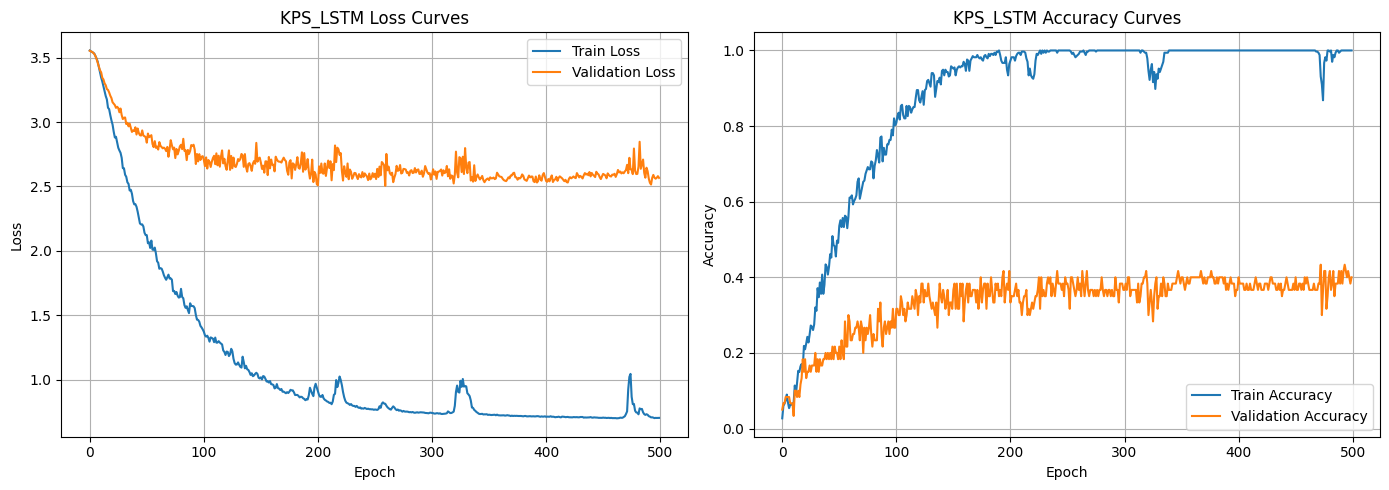

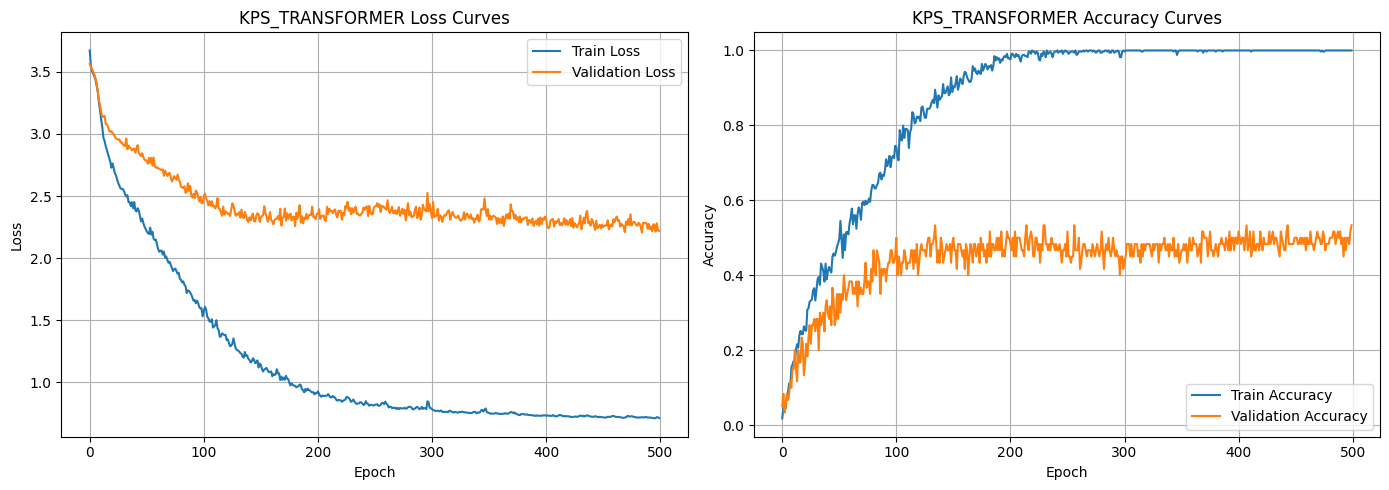

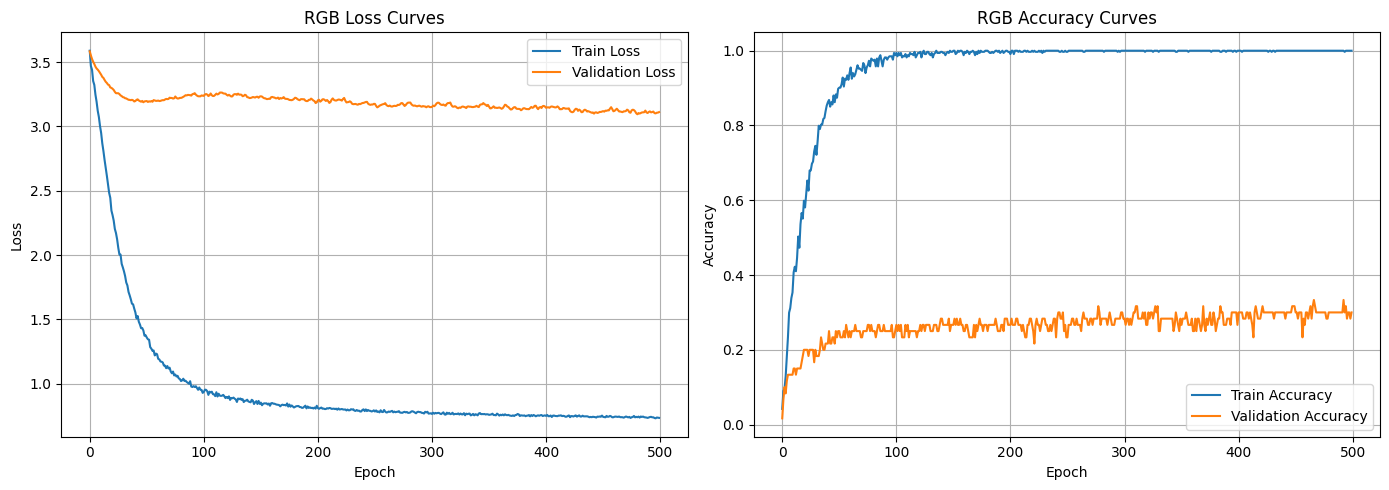

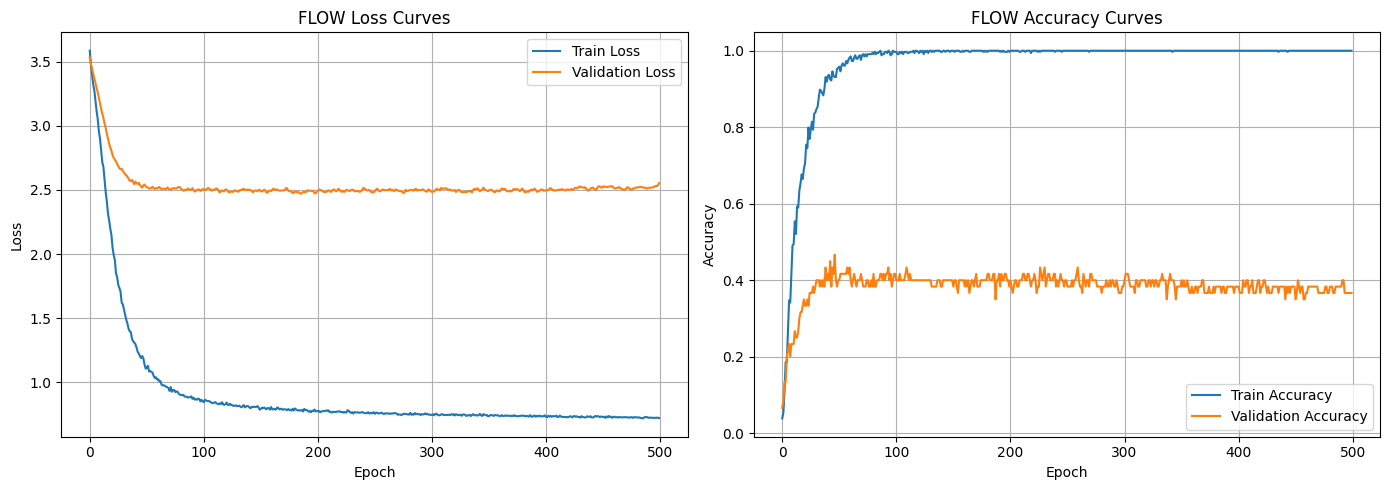

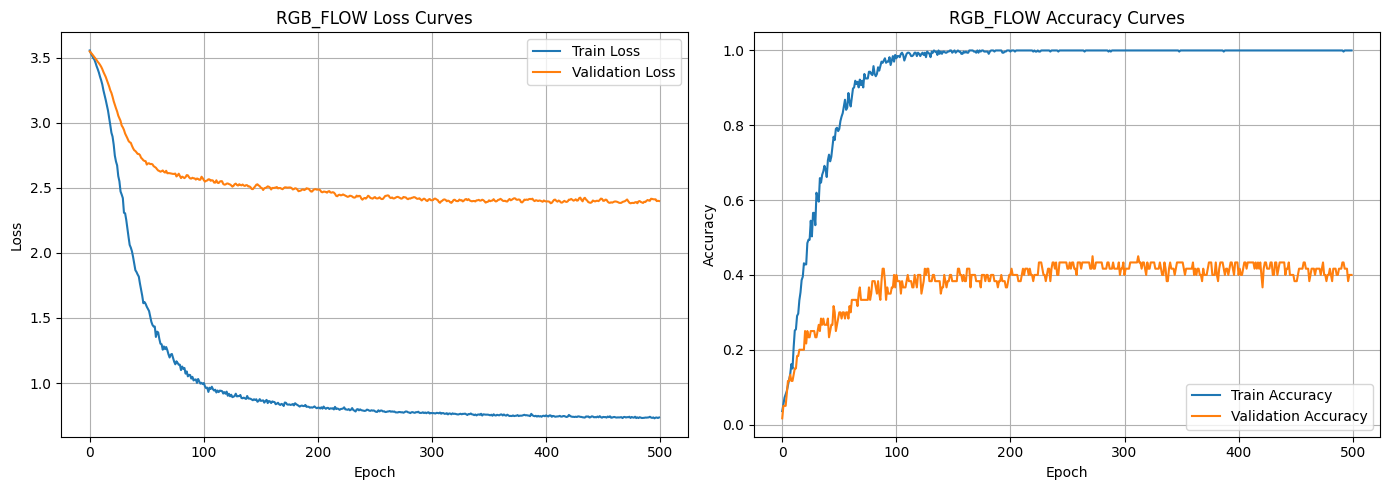

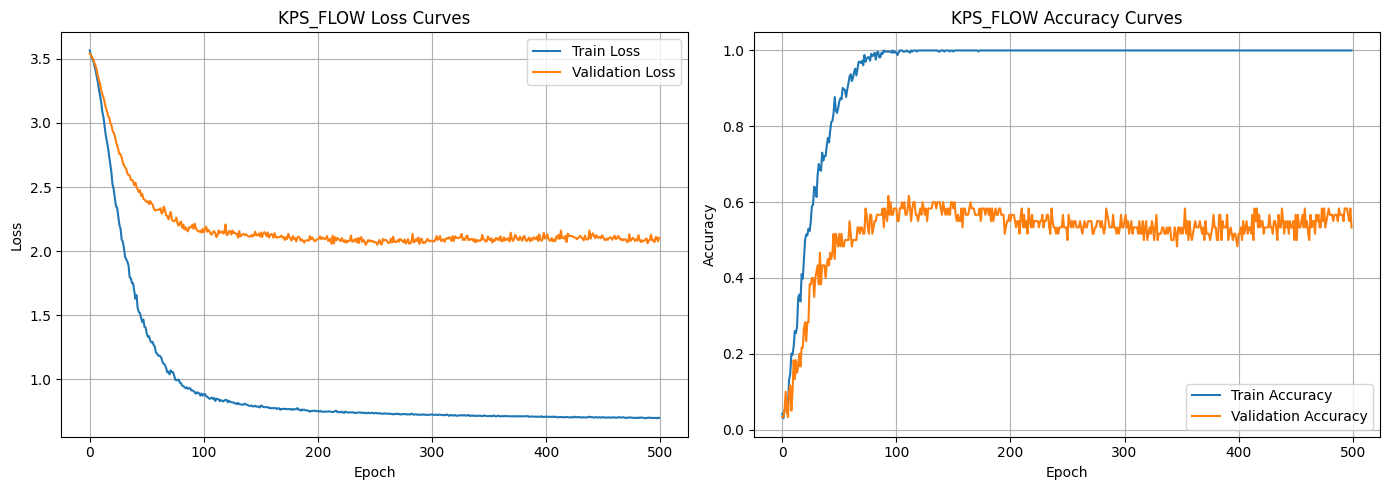

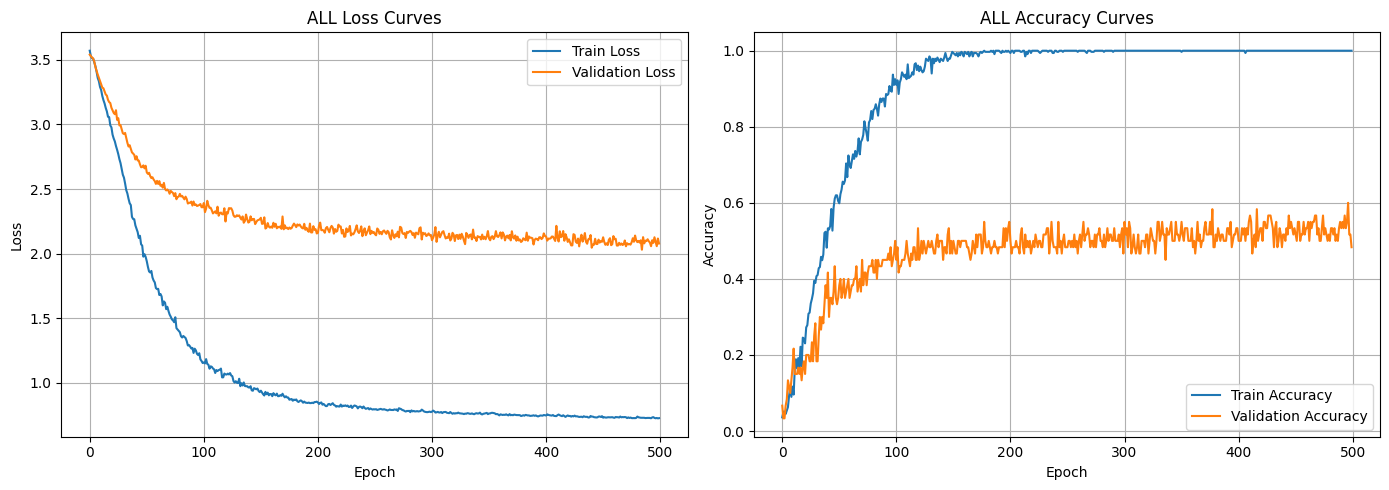

In [164]:
# Plot results for each experiment
for experiment_mode, results in global_results.items():
    plot_loss_and_accuracy(
        results["history"]["train_loss"],
        results["history"]["val_loss"],
        results["history"]["train_acc"],
        results["history"]["val_acc"],
        title_prefix=experiment_mode.upper(),
    )

## 6. Comparison & Analysis

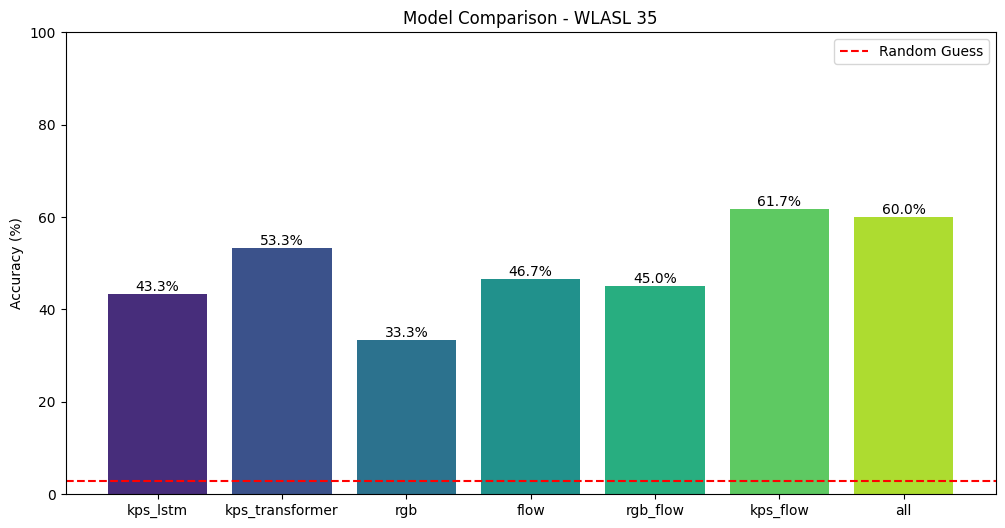

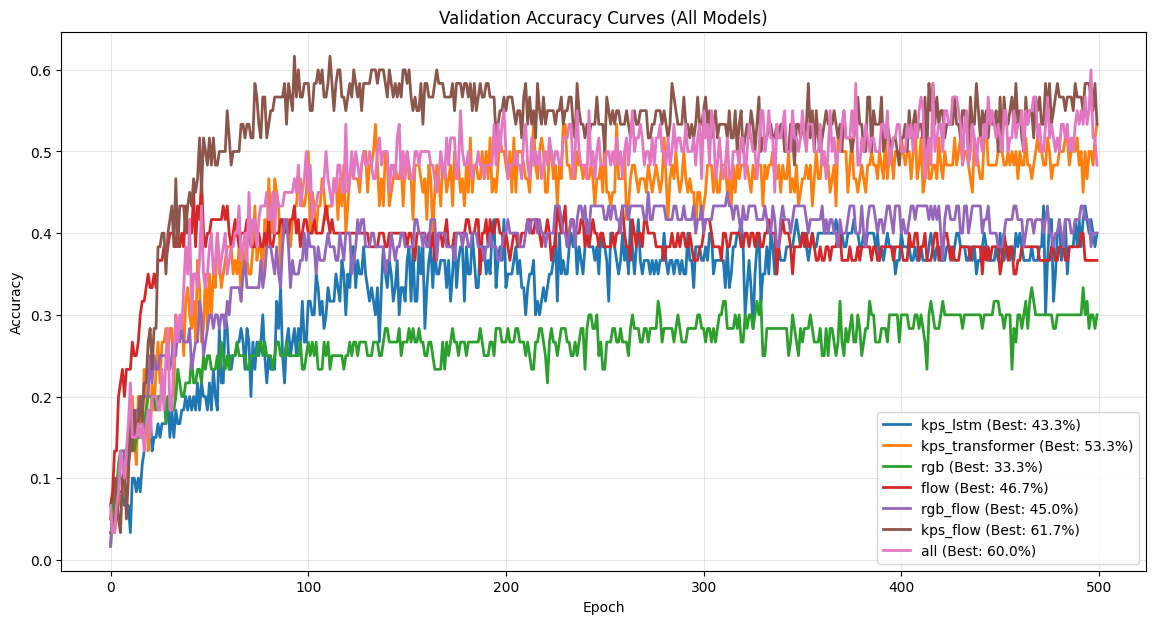


REPORT: KPS_LSTM
              precision    recall  f1-score   support

    accident     0.0000    0.0000    0.0000         2
         bad     0.0000    0.0000    0.0000         2
    bathroom     0.0000    0.0000    0.0000         1
         bed     0.5000    0.5000    0.5000         2
      before     0.5000    0.5000    0.5000         2
     bowling     0.6667    1.0000    0.8000         2
       candy     0.3333    0.5000    0.4000         2
    computer     0.6667    1.0000    0.8000         2
        cool     0.5000    0.5000    0.5000         2
      cousin     1.0000    0.5000    0.6667         2
      doctor     0.5000    1.0000    0.6667         2
       drink     0.3333    0.5000    0.4000         2
        find     0.5000    1.0000    0.6667         1
          go     0.5000    0.5000    0.5000         2
        good     0.0000    0.0000    0.0000         2
        help     0.0000    0.0000    0.0000         2
    hospital     0.0000    0.0000    0.0000         1
         

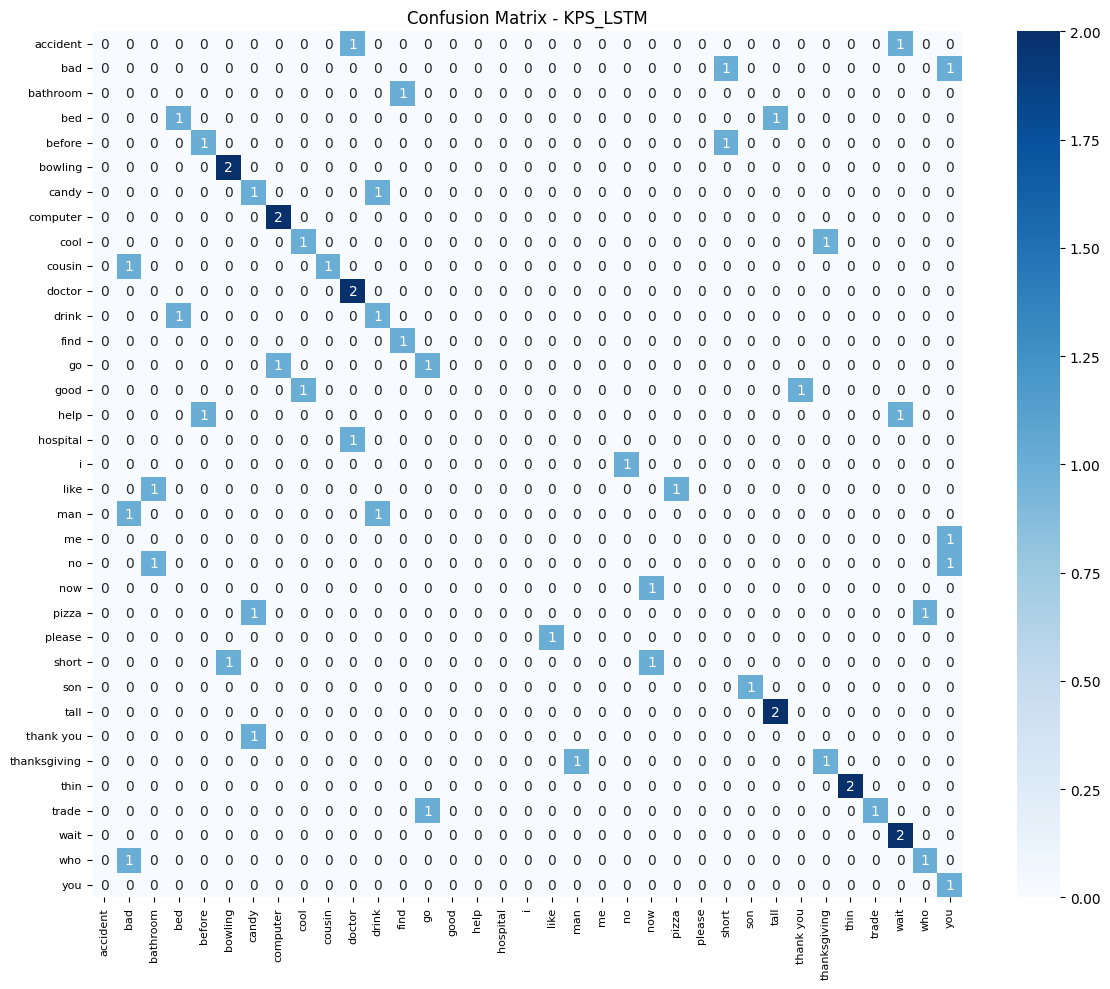


REPORT: KPS_TRANSFORMER
              precision    recall  f1-score   support

    accident     0.5000    0.5000    0.5000         2
         bad     0.2500    0.5000    0.3333         2
    bathroom     0.0000    0.0000    0.0000         1
         bed     1.0000    1.0000    1.0000         2
      before     0.6667    1.0000    0.8000         2
     bowling     0.5000    0.5000    0.5000         2
       candy     0.2500    0.5000    0.3333         2
    computer     1.0000    1.0000    1.0000         2
        cool     1.0000    0.5000    0.6667         2
      cousin     1.0000    0.5000    0.6667         2
      doctor     0.0000    0.0000    0.0000         2
       drink     0.5000    0.5000    0.5000         2
        find     0.0000    0.0000    0.0000         1
          go     0.6667    1.0000    0.8000         2
        good     0.0000    0.0000    0.0000         2
        help     1.0000    1.0000    1.0000         2
    hospital     1.0000    1.0000    1.0000         1
  

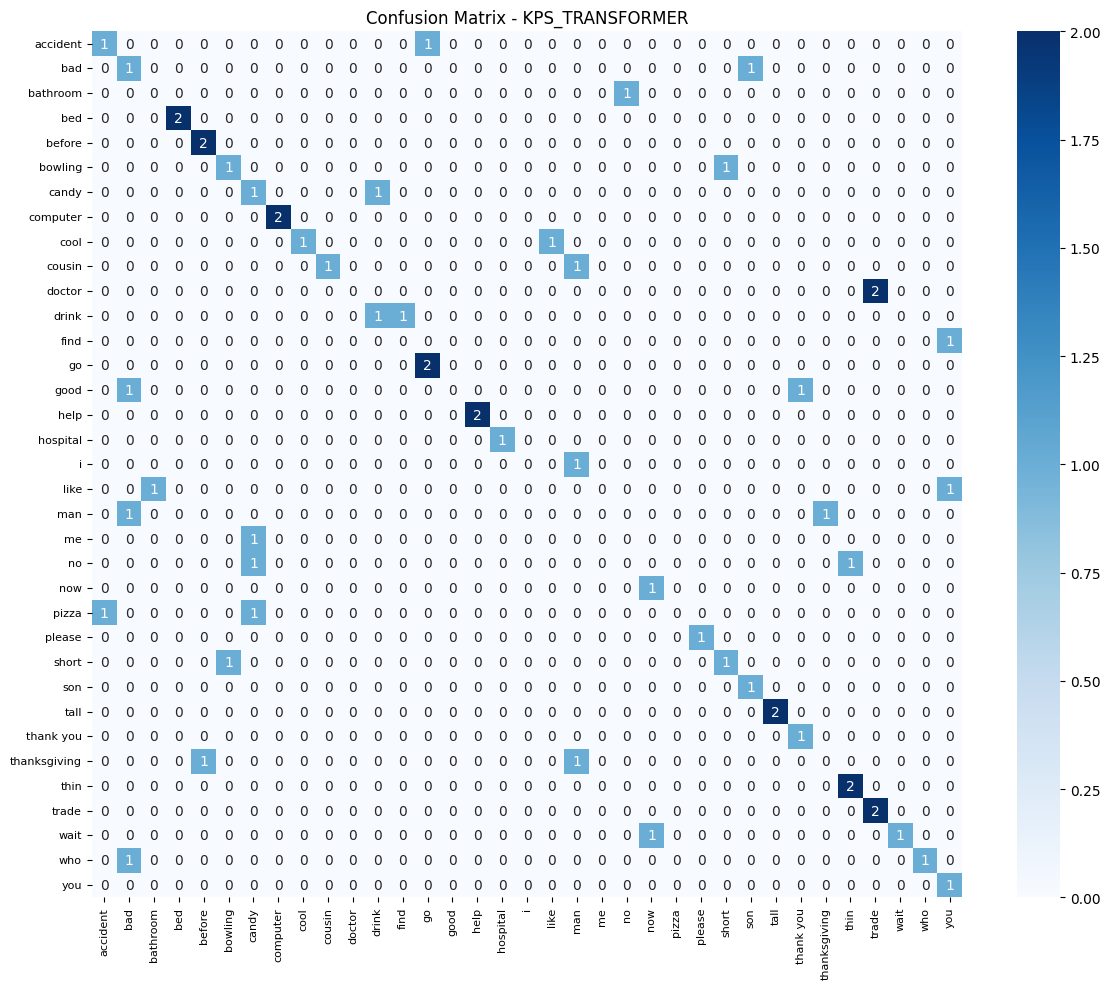


REPORT: RGB
              precision    recall  f1-score   support

    accident     0.0000    0.0000    0.0000         2
         bad     0.2000    0.5000    0.2857         2
    bathroom     0.0000    0.0000    0.0000         1
         bed     0.6667    1.0000    0.8000         2
      before     0.3333    0.5000    0.4000         2
     bowling     1.0000    0.5000    0.6667         2
       candy     0.0000    0.0000    0.0000         2
    computer     1.0000    0.5000    0.6667         2
        cool     1.0000    0.5000    0.6667         2
      cousin     0.6667    1.0000    0.8000         2
      doctor     0.5000    1.0000    0.6667         2
       drink     0.3333    0.5000    0.4000         2
        find     0.0000    0.0000    0.0000         1
          go     0.5000    0.5000    0.5000         2
        good     0.0000    0.0000    0.0000         2
        help     0.3333    0.5000    0.4000         2
    hospital     0.0000    0.0000    0.0000         1
           i  

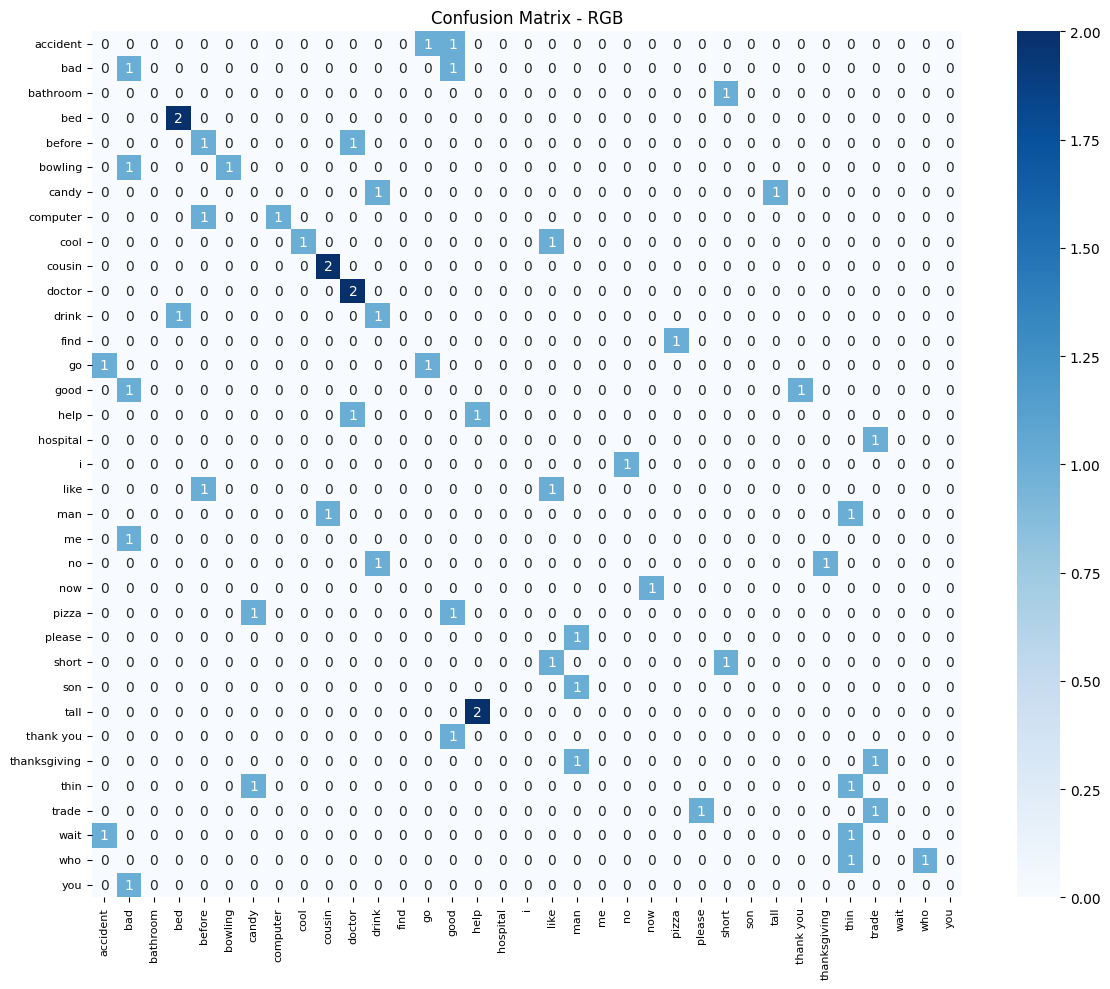


REPORT: FLOW
              precision    recall  f1-score   support

    accident     1.0000    0.5000    0.6667         2
         bad     0.3333    0.5000    0.4000         2
    bathroom     0.0000    0.0000    0.0000         1
         bed     0.6667    1.0000    0.8000         2
      before     0.5000    0.5000    0.5000         2
     bowling     1.0000    1.0000    1.0000         2
       candy     0.0000    0.0000    0.0000         2
    computer     1.0000    0.5000    0.6667         2
        cool     0.4000    1.0000    0.5714         2
      cousin     0.3333    0.5000    0.4000         2
      doctor     1.0000    1.0000    1.0000         2
       drink     0.3333    0.5000    0.4000         2
        find     0.0000    0.0000    0.0000         1
          go     0.5000    1.0000    0.6667         2
        good     0.0000    0.0000    0.0000         2
        help     1.0000    0.5000    0.6667         2
    hospital     0.0000    0.0000    0.0000         1
           i 

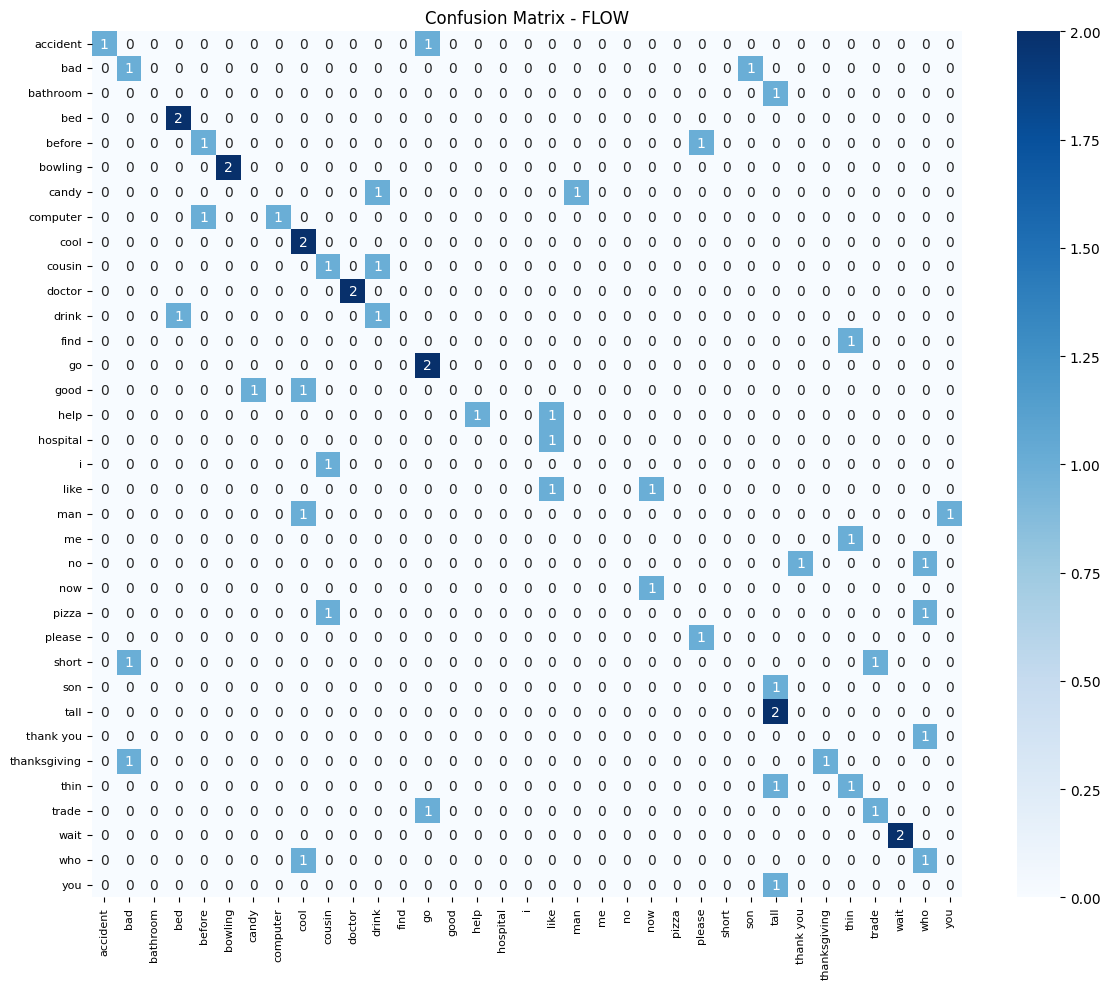


REPORT: RGB_FLOW
              precision    recall  f1-score   support

    accident     0.3333    0.5000    0.4000         2
         bad     0.5000    0.5000    0.5000         2
    bathroom     0.0000    0.0000    0.0000         1
         bed     0.5000    1.0000    0.6667         2
      before     0.0000    0.0000    0.0000         2
     bowling     0.5000    0.5000    0.5000         2
       candy     0.0000    0.0000    0.0000         2
    computer     0.5000    0.5000    0.5000         2
        cool     1.0000    0.5000    0.6667         2
      cousin     1.0000    0.5000    0.6667         2
      doctor     1.0000    1.0000    1.0000         2
       drink     0.6667    1.0000    0.8000         2
        find     0.0000    0.0000    0.0000         1
          go     0.5000    0.5000    0.5000         2
        good     0.0000    0.0000    0.0000         2
        help     0.3333    0.5000    0.4000         2
    hospital     1.0000    1.0000    1.0000         1
         

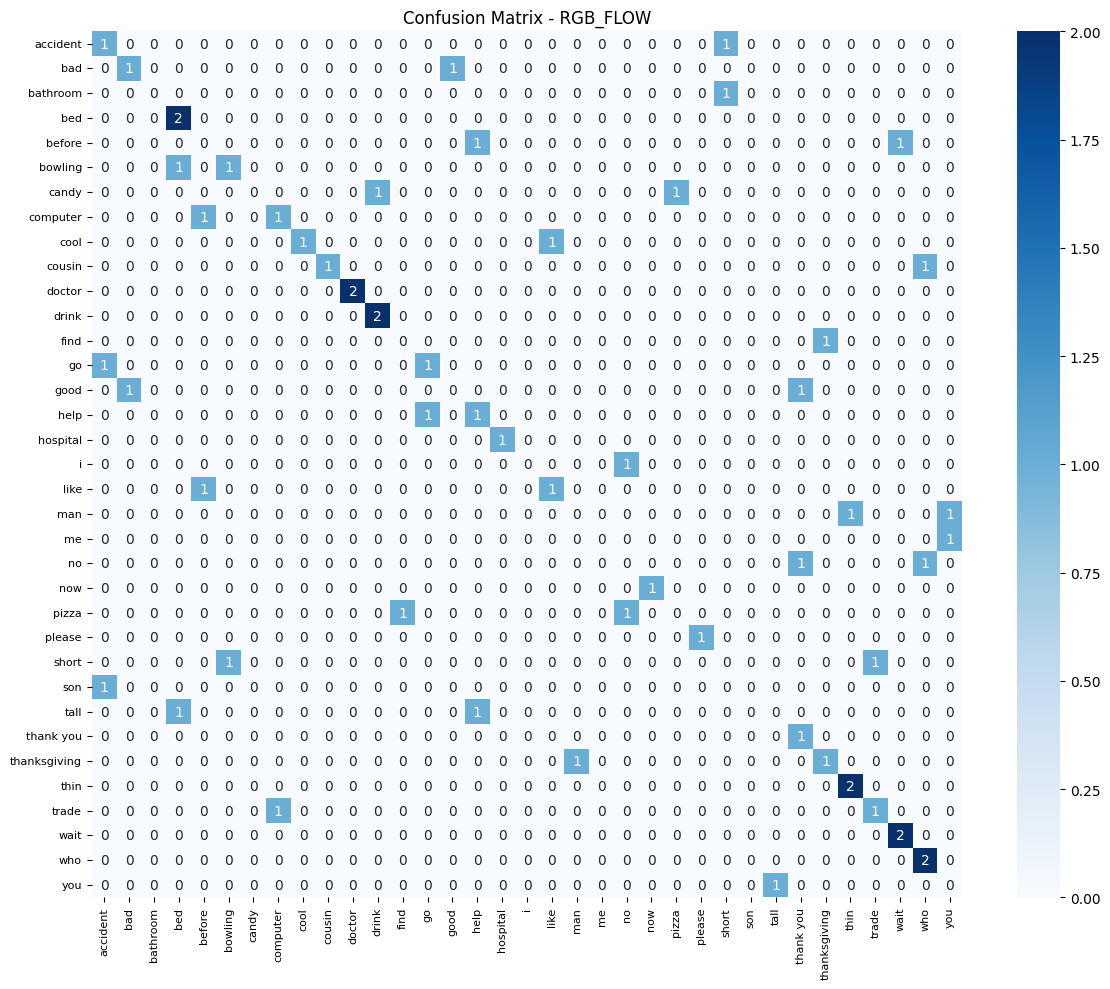


REPORT: KPS_FLOW
              precision    recall  f1-score   support

    accident     1.0000    1.0000    1.0000         2
         bad     0.3333    0.5000    0.4000         2
    bathroom     0.0000    0.0000    0.0000         1
         bed     1.0000    1.0000    1.0000         2
      before     0.6667    1.0000    0.8000         2
     bowling     1.0000    1.0000    1.0000         2
       candy     0.0000    0.0000    0.0000         2
    computer     1.0000    1.0000    1.0000         2
        cool     1.0000    0.5000    0.6667         2
      cousin     0.5000    0.5000    0.5000         2
      doctor     1.0000    1.0000    1.0000         2
       drink     0.6667    1.0000    0.8000         2
        find     0.5000    1.0000    0.6667         1
          go     1.0000    1.0000    1.0000         2
        good     0.0000    0.0000    0.0000         2
        help     1.0000    0.5000    0.6667         2
    hospital     1.0000    1.0000    1.0000         1
         

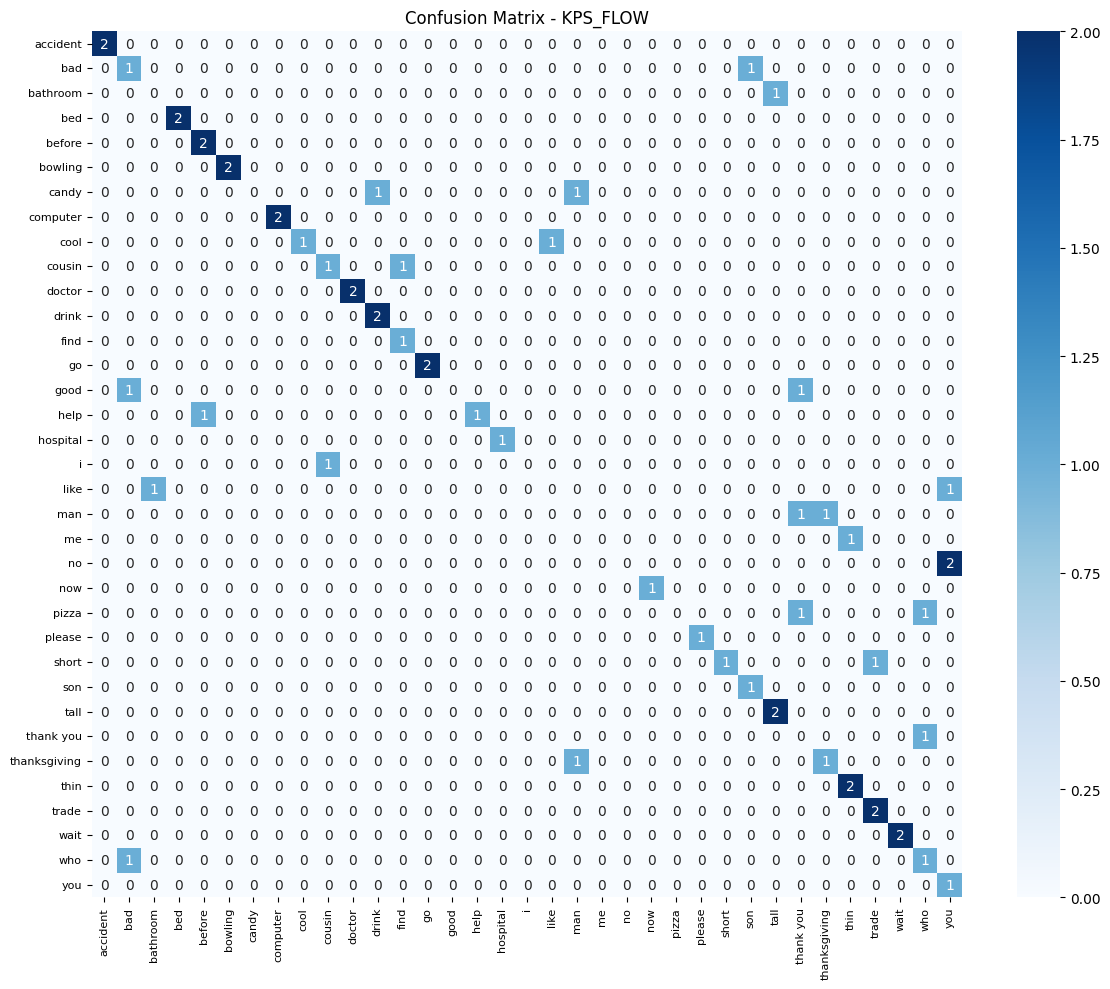


REPORT: ALL
              precision    recall  f1-score   support

    accident     0.0000    0.0000    0.0000         2
         bad     0.6667    1.0000    0.8000         2
    bathroom     0.0000    0.0000    0.0000         1
         bed     0.6667    1.0000    0.8000         2
      before     0.5000    0.5000    0.5000         2
     bowling     1.0000    1.0000    1.0000         2
       candy     0.0000    0.0000    0.0000         2
    computer     1.0000    1.0000    1.0000         2
        cool     0.5000    0.5000    0.5000         2
      cousin     0.5000    0.5000    0.5000         2
      doctor     0.6667    1.0000    0.8000         2
       drink     0.6667    1.0000    0.8000         2
        find     1.0000    1.0000    1.0000         1
          go     0.6667    1.0000    0.8000         2
        good     0.0000    0.0000    0.0000         2
        help     0.5000    0.5000    0.5000         2
    hospital     1.0000    1.0000    1.0000         1
           i  

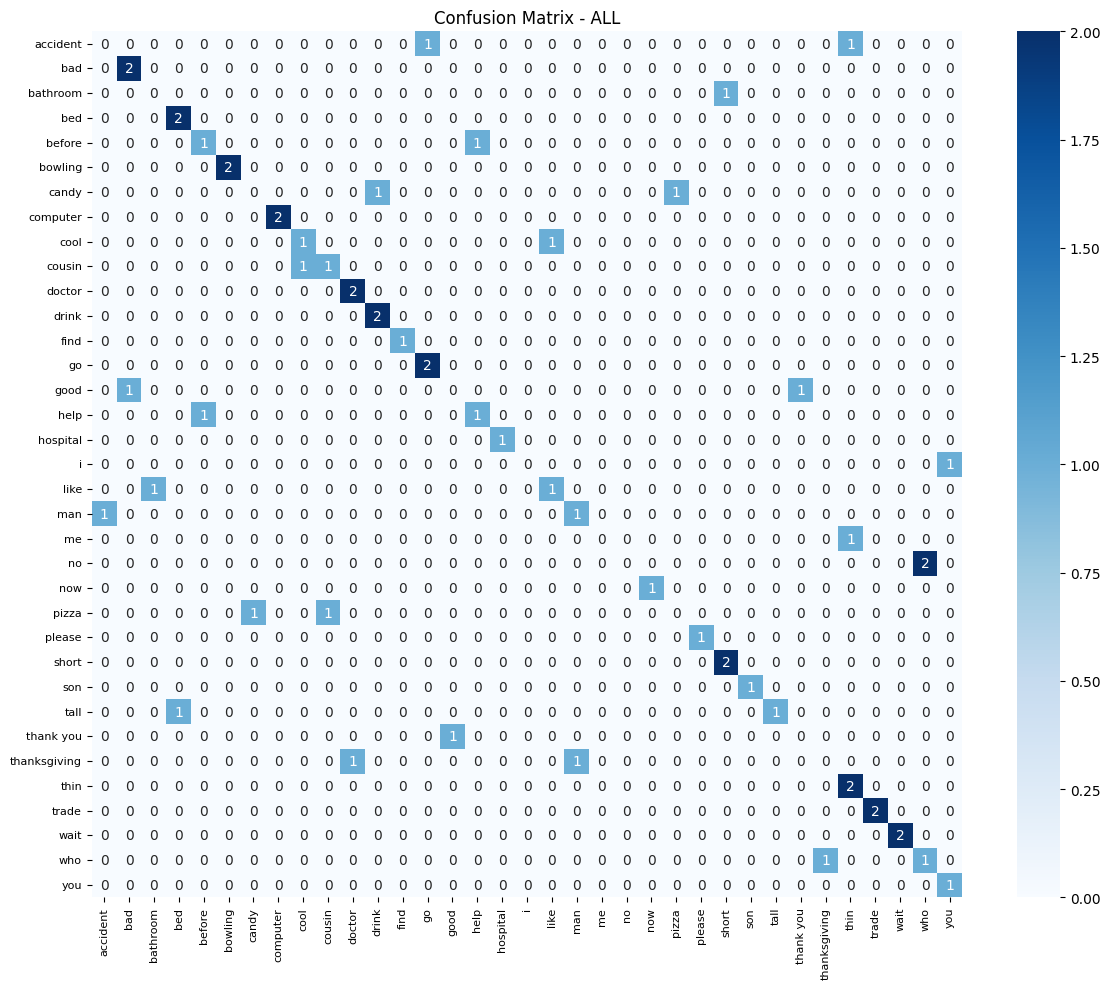

In [165]:
# --- 1. Comparative Accuracy Plot ---
plt.figure(figsize=(12, 6))
names = list(global_results.keys())
values = [res["best_acc"] * 100 for res in global_results.values()]
colors = sns.color_palette("viridis", len(names))

bars = plt.bar(names, values, color=colors)
plt.title("Model Comparison - WLASL 35")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
# Plot a horizontal line for random chance (1 / num_classes)
num_classes = CONFIG["num_classes"]
plt.axhline(y=100 / num_classes, color="r", linestyle="--", label="Random Guess")
plt.legend()
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
    )
plt.show()

# --- 2. Combined Learning Curves ---
plt.figure(figsize=(14, 7))
for mode, res in global_results.items():
    plt.plot(
        res["history"]["val_acc"],
        label=f"{mode} (Best: {res['best_acc'] * 100:.1f}%)",
        linewidth=2,
    )

plt.title("Validation Accuracy Curves (All Models)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 3. Individual Reports ---
gloss2idx = json.load(open(CONFIG["gloss_map"]))
idx2gloss = {v: k for k, v in gloss2idx.items()}
labels = list(range(len(gloss2idx)))
target_names = [idx2gloss[i] for i in labels]

for mode, res in global_results.items():
    print(f"\n{'=' * 40}")
    print(f"REPORT: {mode.upper()}")
    print(f"{'=' * 40}")

    # Added zero_division=0 to silence warnings
    print(
        classification_report(
            res["y_true"],
            res["y_pred"],
            target_names=target_names,
            digits=4,
            zero_division=0,
        )
    )

    # Confusion Matrix, put number in cells
    cm = confusion_matrix(res["y_true"], res["y_pred"], labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=target_names,
        yticklabels=target_names,
    )
    plt.title(f"Confusion Matrix - {mode.upper()}")
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

## 7. Class-wise Analysis on Best Model

🏆 Best Overall Model: KPS_FLOW with Accuracy: 61.67%
Loading weights from: d:\jherng\Workspace\university\masters\courses\year2526_sem1\wqf7002_artificial_intelligence_techniques\assignment\sign-language-model\checkpoints\best_model_kps_flow.pth
>>> Running Final Inference on Test Set...


Loaded 35 classes.


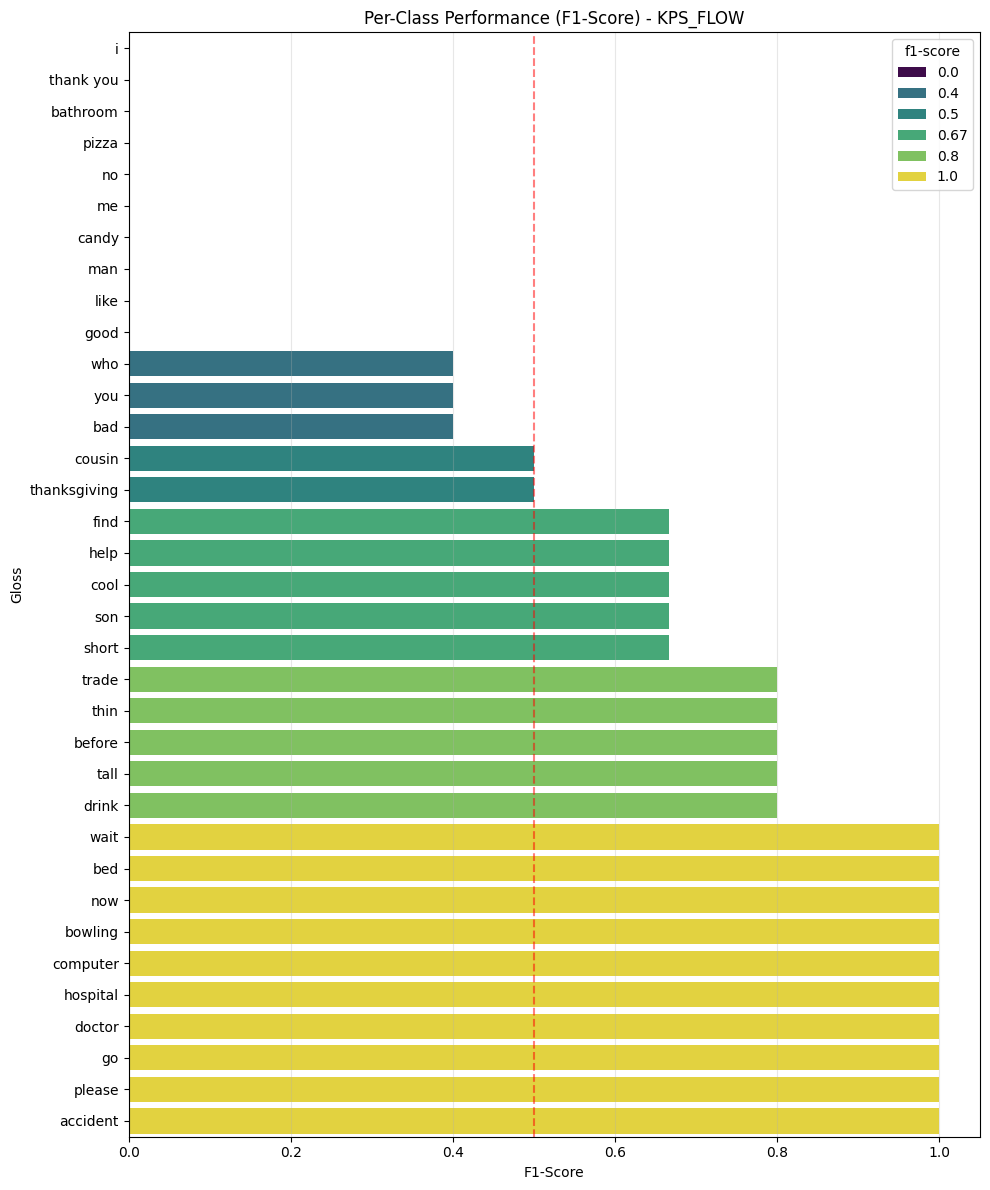


🏆 TOP 5 PERFORMING CLASSES (Mastered)
          precision  recall  f1-score
accident        1.0     1.0       1.0
please          1.0     1.0       1.0
go              1.0     1.0       1.0
doctor          1.0     1.0       1.0
hospital        1.0     1.0       1.0

⚠️ WORST 5 PERFORMING CLASSES (Confused)
           precision  recall  f1-score
i                0.0     0.0       0.0
thank you        0.0     0.0       0.0
bathroom         0.0     0.0       0.0
pizza            0.0     0.0       0.0
no               0.0     0.0       0.0

🔄 TOP CONFUSION PAIRS (Common Mistakes)
  True Gloss Predicted As  Count
          no          you      2
         bad          son      1
    bathroom         tall      1
thanksgiving          man      1
   thank you          who      1
       short        trade      1
       pizza          who      1
       pizza    thank you      1
          me         thin      1
         man thanksgiving      1


In [180]:
# --- 1. Auto-Detect Best Model from Results ---
# Find the experiment key with the highest 'best_acc'
best_name, best_data = max(global_results.items(), key=lambda x: x[1]['best_acc'])
print(f"🏆 Best Overall Model: {best_name.upper()} with Accuracy: {best_data['best_acc'] * 100:.2f}%")

# --- 2. Load That Specific Model ---
# Initialize the architecture matching the best run
best_model = get_model(best_name, CONFIG).to(CONFIG["device"])

# Construct the correct filename
weights_path = os.path.join(CONFIG["save_dir"], f"best_model_{best_name}.pth")
print(f"Loading weights from: {weights_path}")

best_model.load_state_dict(torch.load(weights_path))
best_model.eval()

# --- 3. Run Inference ---
print(">>> Running Final Inference on Test Set...")
# Pass 'best_name' as the mode so it knows how to handle inputs (kps vs rgb etc)
loss, acc, y_true, y_pred = validate_one_epoch(
    best_model, test_loader, criterion, CONFIG["device"], best_name
)

# --- 4. Robust Label Loading (The Fix) ---
with open(CONFIG["gloss_map"], "r") as f:
    raw_data = json.load(f)

target_names = []

if isinstance(raw_data, list):
    # Case 1: List ["book", "drink"]
    target_names = raw_data
elif isinstance(raw_data, dict):
    # Case 2: Dict {"book": 0} OR {"0": "book"}
    first_val = list(raw_data.values())[0]
    if isinstance(first_val, int):
        # Format: {"book": 0} -> Sort by value (index)
        sorted_pairs = sorted(raw_data.items(), key=lambda item: item[1])
        target_names = [k for k, v in sorted_pairs]
    else:
        # Format: {"0": "book"} -> Sort by key (index)
        sorted_pairs = sorted(raw_data.items(), key=lambda item: int(item[0]))
        target_names = [v for k, v in sorted_pairs]

print(f"Loaded {len(target_names)} classes.")

# --- 5. Generate Report ---
report = classification_report(
    y_true, 
    y_pred, 
    target_names=target_names, 
    output_dict=True, 
    zero_division=0
)

# Create DataFrame
df_report = pd.DataFrame(report).transpose()
# Drop summary rows to focus on classes
df_classes = df_report.iloc[:-3].sort_values(by="f1-score", ascending=True)

# --- 6. Visualization: Performance Bar Chart ---
plt.figure(figsize=(10, 12))
sns.barplot(x=df_classes["f1-score"], y=df_classes.index, palette="viridis", hue=df_classes["f1-score"].round(2))
plt.axvline(0.5, color="r", linestyle="--", alpha=0.5)
plt.title(f"Per-Class Performance (F1-Score) - {best_name.upper()}")
plt.xlabel("F1-Score")
plt.ylabel("Gloss")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# --- 7. Best & Worst Classes ---
print(f"\n{'='*40}")
print("🏆 TOP 5 PERFORMING CLASSES (Mastered)")
print(f"{'='*40}")
print(df_classes.tail(5)[::-1][["precision", "recall", "f1-score"]])

print(f"\n{'='*40}")
print("⚠️ WORST 5 PERFORMING CLASSES (Confused)")
print(f"{'='*40}")
print(df_classes.head(5)[["precision", "recall", "f1-score"]])

# --- 8. Top Confusion Pairs ---
cm = confusion_matrix(y_true, y_pred)
confusions = []

for i in range(len(target_names)):
    for j in range(len(target_names)):
        if i != j and cm[i, j] > 0: # If mistakenly predicted
            confusions.append({
                "True Gloss": target_names[i],
                "Predicted As": target_names[j],
                "Count": cm[i, j]
            })

df_confusions = pd.DataFrame(confusions).sort_values(by="Count", ascending=False)

print(f"\n{'='*40}")
print("🔄 TOP CONFUSION PAIRS (Common Mistakes)")
print(f"{'='*40}")
if not df_confusions.empty:
    print(df_confusions.head(10).to_string(index=False))
else:
    print("No significant confusions found.")

In [183]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Prepare container for metrics
metrics_list = []

# 2. Iterate through your global_results dictionary
for model_name, result_data in global_results.items():
    y_true = result_data['y_true']
    y_pred = result_data['y_pred']
    
    # Calculate Metrics
    # We use average='weighted' to account for any class imbalance. 
    # Use 'macro' if you want to treat every class equally regardless of sample size.
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, 
        y_pred, 
        average='weighted', 
        zero_division=0
    )
    
    metrics_list.append({
        "Model": model_name.upper(),
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

# 3. Create DataFrame
df_results = pd.DataFrame(metrics_list)

# 4. Sort by Accuracy (Best on top)
df_results = df_results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

# 5. Display
print(">>> Model Performance Summary")
# formatting floats to 4 decimal places
print(df_results.to_string(index=False, float_format="%.4f"))

# Optional: If you are in Jupyter/Colab, you can just type 'df_results' in a cell to see a pretty HTML table
# df_results

>>> Model Performance Summary
          Model  Accuracy  Precision  Recall  F1-Score
       KPS_FLOW    0.6167     0.5708  0.6167    0.5722
            ALL    0.6000     0.5194  0.6000    0.5456
KPS_TRANSFORMER    0.5333     0.4972  0.5333    0.4883
           FLOW    0.4667     0.4106  0.4667    0.4068
       RGB_FLOW    0.4500     0.3944  0.4500    0.4039
       KPS_LSTM    0.4333     0.3597  0.4333    0.3744
            RGB    0.3333     0.3150  0.3333    0.3017
